In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


In [ ]:
!pip install torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=537340 sha256=a1828d4f15c24fee42df2abbfd75ccb4695a577e3527d6a0cf6bff7f65a38bba
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter


In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import warnings
from tqdm.notebook import tqdm
import time
import random
import os
import joblib
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.validation import check_random_state
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostRegressor
from catboost import Pool
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
import optuna

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch_geometric
from torch.nn import Dropout, BatchNorm1d
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn import GraphConv, TopKPooling, GCNConv, GATConv, GINConv, EdgeConv
from torch_scatter import scatter
from pytorch_tabnet.tab_network import AttentiveTransformer, FeatTransformer

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Lipinski, EState, MolSurf, Fragments, Descriptors, rdMolDescriptors, rdFingerprintGenerator, Crippen, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdchem import BondType

import deepchem as dc
from deepchem.models.torch_models import MPNNModel

from google.colab import drive

drive.mount('./drive')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Mounted at ./drive


In [ ]:
CFG = {
    'SEED': 42
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    check_random_state(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

Molecule ChEMBL ID:

 - ChEMBL 데이터베이스에서 각 분자를 고유하게 식별하는 ID

Standard Type:

 - 측정된 생물학적 활동의 유형, IC50, EC50, Ki 등

Standard Relation:

 - 측정된 값과의 관계, "=", "<", ">" 등

Standard Value:

 - 측정된 생물학적 활동 값, IC50 값이 될 수 있음.

Standard Units:

 - Standard Value의 단위, nM(나노몰), μM 과 같은 단위

pChEMBL Value:

 - Standard Value의 로그 변환된 값으로, pIC50, pKi 등을 포함. 일반적으로 -log10(Standard Value)로 계산

Assay ChEMBL ID:

 - 해당 실험(Assay)을 고유하게 식별하는 ID

Target ChEMBL ID:

 - 실험 대상을 고유하게 식별하는 ID

Target Name:

 - 실험 대상의 이름. 단백질이나 효소의 이름

Target Organism:

 - 실험 대상이 속한 생물 종. "Homo sapiens"는 인간을 나타냄

Target Type:

 - 실험 대상의 종류. 단백질, 세포 등으로 분류

Document ChEMBL ID:

 - 해당 데이터가 출처한 문서를 식별하는 ID

IC50는 특정 약물이 생물학적 과정 또는 효소의 활성 등을 50% 억제하는 데 필요한 약물 농도를 의미.

단위는 보통 nM(나노몰), μM(마이크로몰) 등이 사용.

IC50 값이 낮을수록 해당 약물은 더 강력한 억제제라는 것을 의미.

pIC50는 IC50 값을 음의 로그 값으로 변환한 것, pIC50 = -log10(IC50)

pIC50 값이 클수록 약물이 더 높은 효능을 가지고, IC50이 낮을수록 pIC50은 높아짐.

In [ ]:
descriptor_functions = {
    'BCUT2D_CHGHI': Descriptors.BCUT2D_CHGHI,
    'BCUT2D_CHGLO': Descriptors.BCUT2D_CHGLO,
    'BCUT2D_LOGPHI': Descriptors.BCUT2D_LOGPHI,
    'BCUT2D_LOGPLOW': Descriptors.BCUT2D_LOGPLOW,
    'BCUT2D_MRHI': Descriptors.BCUT2D_MRHI,
    'BCUT2D_MRLOW': Descriptors.BCUT2D_MRLOW,
    'BCUT2D_MWHI': Descriptors.BCUT2D_MWHI,
    'BCUT2D_MWLOW': Descriptors.BCUT2D_MWLOW,
    'BalabanJ': Descriptors.BalabanJ,
    'BertzCT': Descriptors.BertzCT,
    'Chi0': Descriptors.Chi0,
    'Chi0n': Descriptors.Chi0n,
    'Chi0v': Descriptors.Chi0v,
    'Chi1': Descriptors.Chi1,
    'Chi1n': Descriptors.Chi1n,
    'Chi1v': Descriptors.Chi1v,
    'Chi2n': Descriptors.Chi2n,
    'Chi2v': Descriptors.Chi2v,
    'Chi3n': Descriptors.Chi3n,
    'Chi3v': Descriptors.Chi3v,
    'Chi4n': Descriptors.Chi4n,
    'Chi4v': Descriptors.Chi4v,
    'EState_VSA1': Descriptors.EState_VSA1,
    'EState_VSA10': Descriptors.EState_VSA10,
    'EState_VSA11': Descriptors.EState_VSA11,
    'EState_VSA2': Descriptors.EState_VSA2,
    'EState_VSA3': Descriptors.EState_VSA3,
    'EState_VSA4': Descriptors.EState_VSA4,
    'EState_VSA5': Descriptors.EState_VSA5,
    'EState_VSA6': Descriptors.EState_VSA6,
    'EState_VSA7': Descriptors.EState_VSA7,
    'EState_VSA8': Descriptors.EState_VSA8,
    'EState_VSA9': Descriptors.EState_VSA9,
    'ExactMolWt': Descriptors.ExactMolWt,
    'FpDensityMorgan1': Descriptors.FpDensityMorgan1,
    'FpDensityMorgan2': Descriptors.FpDensityMorgan2,
    'FpDensityMorgan3': Descriptors.FpDensityMorgan3,
    'FractionCSP3': Descriptors.FractionCSP3,
    'HallKierAlpha': Descriptors.HallKierAlpha,
    'HeavyAtomCount': Descriptors.HeavyAtomCount,
    'HeavyAtomMolWt': Descriptors.HeavyAtomMolWt,
    'Ipc': Descriptors.Ipc,
    'Kappa1': Descriptors.Kappa1,
    'Kappa2': Descriptors.Kappa2,
    'Kappa3': Descriptors.Kappa3,
    'LabuteASA': Descriptors.LabuteASA,
    'MaxAbsEStateIndex': Descriptors.MaxAbsEStateIndex,
    'MaxAbsPartialCharge': Descriptors.MaxAbsPartialCharge,
    'MaxEStateIndex': Descriptors.MaxEStateIndex,
    'MaxPartialCharge': Descriptors.MaxPartialCharge,
    'MinAbsEStateIndex': Descriptors.MinAbsEStateIndex,
    'MinAbsPartialCharge': Descriptors.MinAbsPartialCharge,
    'MinEStateIndex': Descriptors.MinEStateIndex,
    'MinPartialCharge': Descriptors.MinPartialCharge,
    'MolLogP': Descriptors.MolLogP,
    'MolMR': Descriptors.MolMR,
    'MolWt': Descriptors.MolWt,
    'NHOHCount': Descriptors.NHOHCount,
    'NOCount': Descriptors.NOCount,
    'NumAliphaticCarbocycles': Descriptors.NumAliphaticCarbocycles,
    'NumAliphaticHeterocycles': Descriptors.NumAliphaticHeterocycles,
    'NumAliphaticRings': Descriptors.NumAliphaticRings,
    'NumAromaticCarbocycles': Descriptors.NumAromaticCarbocycles,
    'NumAromaticHeterocycles': Descriptors.NumAromaticHeterocycles,
    'NumAromaticRings': Descriptors.NumAromaticRings,
    'NumHAcceptors': Descriptors.NumHAcceptors,
    'NumHDonors': Descriptors.NumHDonors,
    'NumHeteroatoms': Descriptors.NumHeteroatoms,
    'NumRadicalElectrons': Descriptors.NumRadicalElectrons,
    'NumRotatableBonds': Descriptors.NumRotatableBonds,
    'NumSaturatedCarbocycles': Descriptors.NumSaturatedCarbocycles,
    'NumSaturatedHeterocycles': Descriptors.NumSaturatedHeterocycles,
    'NumSaturatedRings': Descriptors.NumSaturatedRings,
    'NumValenceElectrons': Descriptors.NumValenceElectrons,
    'PEOE_VSA1': Descriptors.PEOE_VSA1,
    'PEOE_VSA10': Descriptors.PEOE_VSA10,
    'PEOE_VSA11': Descriptors.PEOE_VSA11,
    'PEOE_VSA12': Descriptors.PEOE_VSA12,
    'PEOE_VSA13': Descriptors.PEOE_VSA13,
    'PEOE_VSA14': Descriptors.PEOE_VSA14,
    'PEOE_VSA2': Descriptors.PEOE_VSA2,
    'PEOE_VSA3': Descriptors.PEOE_VSA3,
    'PEOE_VSA4': Descriptors.PEOE_VSA4,
    'PEOE_VSA5': Descriptors.PEOE_VSA5,
    'PEOE_VSA6': Descriptors.PEOE_VSA6,
    'PEOE_VSA7': Descriptors.PEOE_VSA7,
    'PEOE_VSA8': Descriptors.PEOE_VSA8,
    'PEOE_VSA9': Descriptors.PEOE_VSA9,
    'RingCount': Descriptors.RingCount,
    'SMR_VSA1': Descriptors.SMR_VSA1,
    'SMR_VSA10': Descriptors.SMR_VSA10,
    'SMR_VSA2': Descriptors.SMR_VSA2,
    'SMR_VSA3': Descriptors.SMR_VSA3,
    'SMR_VSA4': Descriptors.SMR_VSA4,
    'SMR_VSA5': Descriptors.SMR_VSA5,
    'SMR_VSA6': Descriptors.SMR_VSA6,
    'SMR_VSA7': Descriptors.SMR_VSA7,
    'SMR_VSA8': Descriptors.SMR_VSA8,
    'SMR_VSA9': Descriptors.SMR_VSA9,
    'SlogP_VSA1': Descriptors.SlogP_VSA1,
    'SlogP_VSA10': Descriptors.SlogP_VSA10,
    'SlogP_VSA11': Descriptors.SlogP_VSA11,
    'SlogP_VSA12': Descriptors.SlogP_VSA12,
    'SlogP_VSA2': Descriptors.SlogP_VSA2,
    'SlogP_VSA3': Descriptors.SlogP_VSA3,
    'SlogP_VSA4': Descriptors.SlogP_VSA4,
    'SlogP_VSA5': Descriptors.SlogP_VSA5,
    'SlogP_VSA6': Descriptors.SlogP_VSA6,
    'SlogP_VSA7': Descriptors.SlogP_VSA7,
    'SlogP_VSA8': Descriptors.SlogP_VSA8,
    'SlogP_VSA9': Descriptors.SlogP_VSA9,
    'TPSA': Descriptors.TPSA,
    'VSA_EState1': Descriptors.VSA_EState1,
    'VSA_EState10': Descriptors.VSA_EState10,
    'VSA_EState2': Descriptors.VSA_EState2,
    'VSA_EState3': Descriptors.VSA_EState3,
    'VSA_EState4': Descriptors.VSA_EState4,
    'VSA_EState5': Descriptors.VSA_EState5,
    'VSA_EState6': Descriptors.VSA_EState6,
    'VSA_EState7': Descriptors.VSA_EState7,
    'VSA_EState8': Descriptors.VSA_EState8,
    'VSA_EState9': Descriptors.VSA_EState9,
    'fr_Al_COO': Fragments.fr_Al_COO,
    'fr_Al_OH_noTert': Fragments.fr_Al_OH_noTert,
    'fr_Ar_COO': Fragments.fr_Ar_COO,
    'fr_Ar_N': Fragments.fr_Ar_N,
    'fr_Ar_NH': Fragments.fr_Ar_NH,
    'fr_Ar_OH': Fragments.fr_Ar_OH,
    'fr_COO': Fragments.fr_COO,
    'fr_C_O': Fragments.fr_C_O,
    'fr_NH0': Fragments.fr_NH0,
    'fr_amide': Fragments.fr_amide,
    'fr_benzene': Fragments.fr_benzene,
    'fr_NH1': Fragments.fr_NH1,
    'fr_Ndealkylation2': Fragments.fr_Ndealkylation2,
    'fr_Nhpyrrole': Fragments.fr_Nhpyrrole,
    'fr_ester': Fragments.fr_ester,
    'fr_ether': Fragments.fr_ether,
    'fr_bicyclic': Fragments.fr_bicyclic,
    'fr_ketone': Fragments.fr_ketone,
    'fr_para_hydroxylation': Fragments.fr_para_hydroxylation,
    'fr_phenol': Fragments.fr_phenol,
    'fr_phenol_noOrthoHbond': Fragments.fr_phenol_noOrthoHbond,
    'fr_thiophene': Fragments.fr_thiophene,
}

In [ ]:
main_root = '/content/drive/MyDrive/newdrug/'

# polars 최신 버전 >> apply -> map_elements

descriptor_columns = []
for func_name, func in descriptor_functions.items():
    descriptor_columns.append(pl.col('Mol').map_elements(func).alias(func_name))

def get_data(path) -> pd.DataFrame:
  return (
      pl.read_csv(path)
      .with_columns(
          # SmilesLength = pl.col('Smiles').map_elements(lambda smiles: len(smiles)),
          Mol = pl.col('Smiles').map_elements(Chem.MolFromSmiles)
      )
      .with_columns(
          pl.col('Mol').map_elements(rdMolDescriptors.CalcTPSA).alias('Molecular_PolarSurfaceArea'),
      )
      .with_columns(
        descriptor_columns
      )
      .drop('Mol')
      .to_pandas()
  )

In [ ]:
train = get_data(main_root + 'train.csv')

Streaming output truncated to the last 5000 lines.
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:32:17] DEPRECATION WARNING: please use MorganGenerator
[20:3

KeyboardInterrupt: 

In [ ]:
# train = train[train['IC50_nM'] < 10000].reset_index().drop('index', axis = 1)

In [ ]:
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,...,fr_Ndealkylation2,fr_Nhpyrrole,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,5,2,0,0,0,0,0
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,0,2,0,0,0,0,0
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,0,0,0,1,2,0,0,0,0,0
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,0,0,0,0,2,0,0,0,0,0
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,2,1,0,0,0,0,0


In [ ]:
train['pIC50']

,pIC50
0,10.66
1,10.59
2,10.11
3,10.09
4,10.00
...,...
1932,5.05
1933,5.05
1934,5.04
1935,5.03


In [ ]:
-np.log10(train['IC50_nM']*(1e-9))

,IC50_nM
0,10.657577
1,10.585027
2,10.107905
3,10.091515
4,10.004365
...,...
1932,5.050610
1933,5.050610
1934,5.036212
1935,5.026087


In [ ]:
# train = train.dropna()

# outliers = train[(train['MolWt'] > 900) |
#                  (train['NumRotatableBonds'] > 20) |
#                  (train['TPSA'] > 250)]

# train = train.drop(index=outliers.index, axis=0)

In [ ]:
def IC50_to_pIC50(ic50_values):
  """
    Convert pIC50 to IC50 (nM).
  """

  IC50_values = np.clip(IC50_values, 1e-10, None)

  return -np.log10(ic50_values) + 9 # -np.log10(ic50_values * (1e-8)) # -np.log10(ic50_values) + 9

def pIC50_to_IC50(pic50_values):
  """
    Convert IC50 (nM) to pIC50.
  """

  return 10 ** (9 - pic50_values) # 10 ** (-pic50_values) * 1e9 # 10 ** (9 - pic50_values)

def round_to_threshold(value, threshold = 1000):
    return np.round(threshold * np.round(value / threshold))

def pIC50_to_IC50_custom(pIC50_values):

    IC50_values = np.round(10 ** (9 - pIC50_values), 3) # np.round(10 ** (-pIC50_values) * 1e9, 3) # np.round(10 ** (9 - pIC50_values), 3)

    IC50_values_threshold = np.array([
        val if val <= 1 else round_to_threshold(val, threshold = 1000)
        for val in IC50_values
    ])

    return IC50_values_threshold

def IC50_to_pIC50_custom(IC50_values):

    IC50_values = np.clip(IC50_values, 1e-10, None)

    pIC50_values = np.round(-np.log10(IC50_values) + 9, 2) # np.round(-np.log10(IC50_values * (1e-8)), 2) # np.round(-np.log10(IC50_values) + 9, 2)

    return pIC50_values

In [ ]:
np.set_printoptions(precision=6, suppress=True) # 표준 10진수 형식으로 표시 설정

In [ ]:
rangeindex = train.loc[train['IC50_nM'] > 0, 'IC50_nM'].index

pIC50_to_IC50_custom(train.loc[rangeindex, 'pIC50']), train.loc[rangeindex, 'IC50_nM']

(array([    0.022,     0.026,     0.078, ...,  9000.   ,  9000.   ,
        10000.   ]),
 0          0.022
 1          0.026
 2          0.078
 3          0.081
 4          0.099
           ...   
 1932    8900.000
 1933    8900.000
 1934    9200.000
 1935    9417.000
 1936    9510.000
 Name: IC50_nM, Length: 1937, dtype: float64)

<Axes: >

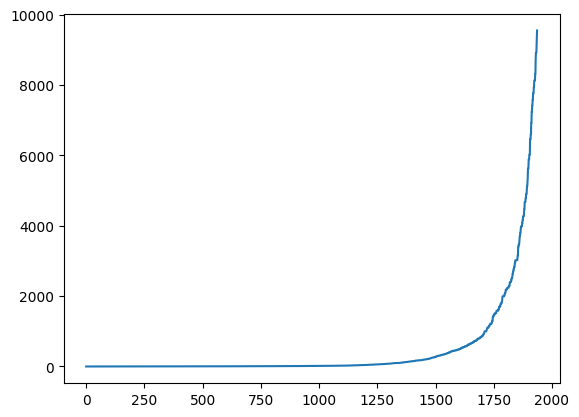

In [ ]:
pIC50_to_IC50(train['pIC50']).plot()

In [ ]:
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,...,fr_Ndealkylation2,fr_Nhpyrrole,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,5,2,0,0,0,0,0
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,0,2,0,0,0,0,0
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,0,0,0,1,2,0,0,0,0,0
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,0,0,0,0,2,0,0,0,0,0
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,2,1,0,0,0,0,0


In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return filtered_df

In [ ]:
# train = remove_outliers_iqr(train, 'IC50_nM')

In [ ]:
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,...,fr_Ndealkylation2,fr_Nhpyrrole,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,5,2,0,0,0,0,0
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,0,2,0,0,0,0,0
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,0,0,0,1,2,0,0,0,0,0
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,0,0,0,0,2,0,0,0,0,0
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,2,1,0,0,0,0,0


In [ ]:
test = get_data(main_root + 'test.csv')

<ipython-input-1136-2c791d1285ab>:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  pl.read_csv(path)
<ipython-input-1136-2c791d1285ab>:16: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithou

In [ ]:
test.head()

,ID,Smiles,Molecular_PolarSurfaceArea,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BCUT2D_MWHI,...,fr_Ndealkylation2,fr_Nhpyrrole,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene
0,TEST_000,O=C(C1=CSC(C2=CC=CN=C2)=N1)NC3=CC(NC4CCN(C)CC4...,79.38,2.213278,-2.300229,2.334139,-2.362354,7.129182,0.101716,32.133482,...,1,0,0,1,0,0,0,0,0,0
1,TEST_001,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(NC4CCCCC4)=...,96.38,2.206217,-2.244014,2.312331,-2.290902,5.829324,0.342986,15.287701,...,0,0,0,0,1,0,0,0,0,0
2,TEST_002,N#CC(C=C1)=C(N[C@@H]2CCNC2)C=C1NC(N=C3)=NC=C3C...,115.51,2.178245,-2.153465,2.250963,-2.221784,5.681345,0.490643,15.299161,...,0,0,0,0,0,0,0,0,0,0
3,TEST_003,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(NC(C=C)=O)CC...,129.78,2.268269,-2.218181,2.317874,-2.321047,5.866868,-0.116638,16.474597,...,0,0,0,1,0,0,0,0,0,0
4,TEST_004,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(N)CC3)=C2C(C...,126.70,2.240016,-2.218036,2.314333,-2.214788,5.748622,0.066238,16.474579,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# 임의의 패턴(원자)를 몇개 포함하고 있는지를 얻는 함수

def number_of_atoms(atom_list, df):
    df['Mol'] = df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))

    atom_columns = {}
    for i in atom_list:
      atom_columns['num_of_{}_atoms'.format(i)] = df['Mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

    df = pd.concat([df, pd.DataFrame(atom_columns)], axis=1)

    return df

train = number_of_atoms(['C', 'O', 'N', 'Cl'], train) # 탄소, 산소, 질소, 염소
test = number_of_atoms(['C','O', 'N', 'Cl'], test)

In [ ]:
train = train.drop('Mol', axis=1)
test = test.drop('Mol', axis=1)

In [ ]:
def compute_morgan_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
        fingerprint = fpgen.GetFingerprint(mol)
        return fingerprint
    else:
        return None

def generate_fingerprint_df(smiles_list, radius, nbits):
    fingerprints = [compute_morgan_fingerprint(smiles, radius=radius, nBits=nbits) for smiles in smiles_list]
    fingerprint_df = pd.DataFrame([list(fp) for fp in fingerprints], columns=[f'bit_{i}' for i in range(len(fingerprints[0]))])
    return fingerprint_df

In [ ]:
# def generate_features(df):
#   resultdict = {}
#   for func_name, func in descriptor_functions.items():
#     try:
#       resultdict[func_name] = df['Mol'].apply(func)
#     except:
#       print('Error', func_name)

#   df = pd.concat([df, pd.DataFrame(resultdict)], axis = 1)

#   return df.drop(['Mol'], axis = 1)

In [ ]:
# train['Mol'] = train['Smiles'].apply(Chem.MolFromSmiles)
# test['Mol'] = test['Smiles'].apply(Chem.MolFromSmiles)

In [ ]:
# train = generate_features(train)
# test = generate_features(test)

In [ ]:
# smiles_list = train['Smiles'].tolist()
# smiles_list_t = test['Smiles'].tolist()

# df_fingerprint = generate_fingerprint_df(smiles_list)
# df_fingerprint_t = generate_fingerprint_df(smiles_list_t)

# train = pd.concat([train, df_fingerprint], axis=1)
# test = pd.concat([test, df_fingerprint_t], axis = 1)

In [ ]:
# def mol2fp(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
#     ar = np.zeros((1,), dtype=np.int8)
#     DataStructs.ConvertToNumpyArray(fp, ar)
#     return ar

# train['FPs'] = train.Smiles.apply(mol2fp)
# test['FPs'] = test.Smiles.apply(mol2fp)

In [ ]:
# X_train_fp = np.array(list(train['FPs']))
# X_test_fp = np.array(list(test['FPs']))

In [ ]:
# selector = VarianceThreshold(threshold=0.05)
# X_train_selected = selector.fit_transform(X_train_fp)
# X_test_selected = selector.transform(X_test_fp)

In [ ]:
# X_train_selected.shape, X_test_selected.shape

In [ ]:
train.shape, test.shape

((1937, 164), (113, 151))

In [ ]:
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,...,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,2,0,0,0,0,0,53,11,8,0
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,2,0,0,0,0,0,28,3,7,0
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,2,0,0,0,0,0,27,4,7,0
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,2,0,0,0,0,0,26,3,7,0
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,1,0,0,0,0,0,51,8,7,0


In [ ]:
matching_df = pd.DataFrame(index=train.columns, columns=train.columns)

def find_matching_columns(df):
    matching_columns = []
    columns = df.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            if df[col1].equals(df[col2]):
                matching_columns.append((col1, col2))
    return matching_columns

matching_pairs = find_matching_columns(train)
print('Matching Pairs:', matching_pairs)

Matching Pairs: [('Standard Value', 'IC50_nM'), ('pChEMBL Value', 'pIC50'), ('Molecular_PolarSurfaceArea', 'TPSA'), ('MaxAbsEStateIndex', 'MaxEStateIndex'), ('NumAromaticCarbocycles', 'fr_benzene'), ('NumRadicalElectrons', 'fr_Ar_COO'), ('SMR_VSA8', 'SlogP_VSA9'), ('fr_Al_COO', 'fr_COO'), ('fr_Ar_NH', 'fr_Nhpyrrole'), ('fr_phenol', 'fr_phenol_noOrthoHbond')]


In [ ]:
drop_cols = []
another_cols = []
for matching_pair in matching_pairs:
  drop_cols.append(matching_pair[0])
  another_cols.append(matching_pair[1])

In [ ]:
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(set(drop_cols).difference(set(['Standard Value', 'pChEMBL Value'])), axis = 1, inplace = True)

In [ ]:
drop_cols

['Standard Value',
 'pChEMBL Value',
 'Molecular_PolarSurfaceArea',
 'MaxAbsEStateIndex',
 'NumAromaticCarbocycles',
 'NumRadicalElectrons',
 'SMR_VSA8',
 'fr_Al_COO',
 'fr_Ar_NH',
 'fr_phenol']

In [ ]:
another_cols

['IC50_nM',
 'pIC50',
 'TPSA',
 'MaxEStateIndex',
 'fr_benzene',
 'fr_Ar_COO',
 'SlogP_VSA9',
 'fr_COO',
 'fr_Nhpyrrole',
 'fr_phenol_noOrthoHbond']

In [ ]:
train.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Units,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,...,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol_noOrthoHbond,fr_thiophene,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,CHEMBL4443947,IC50,'=',nM,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,...,5,2,0,0,0,0,53,11,8,0
1,CHEMBL4556091,IC50,'=',nM,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,...,0,2,0,0,0,0,28,3,7,0
2,CHEMBL4566431,IC50,'=',nM,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,...,1,2,0,0,0,0,27,4,7,0
3,CHEMBL4545898,IC50,'=',nM,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,...,0,2,0,0,0,0,26,3,7,0
4,CHEMBL4448950,IC50,'=',nM,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,...,2,1,0,0,0,0,51,8,7,0


In [ ]:
def get_unique_elements(smiles_list):
    elements = set()
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            for atom in mol.GetAtoms():
                elements.add(atom.GetSymbol())
    return list(elements)

def get_unique_hybridizations(smiles_list):
    hybridizations = set()
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            for atom in mol.GetAtoms():
                hybridizations.add(str(atom.GetHybridization()))
    return list(hybridizations)

# def get_global_min_max(smiles_list):
#   max_degree, min_degree = [], []
#   max_num_hs, min_num_hs = [], []
#   max_implicit_valence, min_implicit_valence = [], []
#   max_formal_charge, min_formal_charge = [], []
#   max_getnumradicalelectrons, min_getnumradicalelectrons = [], []
#   max_getTotaldegree, min_getTotaldegree = [], []
#   max_getnumimpliciths, min_getnumimpliciths = [], []
#   max_getnumexpliciths, min_getnumexpliciths = [], []
#   max_getexplicitvalence, min_getexplicitvalence = [], []
#   max_getTotalvalence, min_getTotalvalence = [], []
#   max_isinring, min_isinring = [], []
#   max_getisaromatic, min_getisaromatic = [], []
#   max_getatomicnum, min_getatomicnum = [], []


#   for smiles in smiles_list:
#     mol = Chem.MolFromSmiles(smiles)
#     if mol:
#       for atom in mol.GetAtoms():
#         max_degree.append(atom.GetDegree())
#         min_degree.append(atom.GetDegree())

#         max_num_hs.append(atom.GetTotalNumHs())
#         min_num_hs.append(atom.GetTotalNumHs())

#         max_implicit_valence.append(atom.GetImplicitValence())
#         min_implicit_valence.append(atom.GetImplicitValence())

#         max_formal_charge.append(atom.GetFormalCharge())
#         min_formal_charge.append(atom.GetFormalCharge())

#         max_getnumradicalelectrons.append(atom.GetNumRadicalElectrons())
#         min_getnumradicalelectrons.append(atom.GetNumRadicalElectrons())

#         max_getTotaldegree.append(atom.GetTotalDegree())
#         min_getTotaldegree.append(atom.GetTotalDegree())

#         max_getnumimpliciths.append(atom.GetNumImplicitHs())
#         min_getnumimpliciths.append(atom.GetNumImplicitHs())

#         max_getnumexpliciths.append(atom.GetNumExplicitHs())
#         min_getnumexpliciths.append(atom.GetNumExplicitHs())

#         max_getexplicitvalence.append(atom.GetExplicitValence())
#         min_getexplicitvalence.append(atom.GetExplicitValence())

#         max_getTotalvalence.append(atom.GetTotalValence())
#         min_getTotalvalence.append(atom.GetTotalValence())

#         max_isinring.append(atom.IsInRing())
#         min_isinring.append(atom.IsInRing())

#         max_getisaromatic.append(atom.GetIsAromatic())
#         min_getisaromatic.append(atom.GetIsAromatic())

#         max_getatomicnum.append(atom.GetAtomicNum())
#         min_getatomicnum.append(atom.GetAtomicNum())

#     return (min(min_degree), max(max_degree)), \
#            (min(min_num_hs), max(max_num_hs)), \
#            (min(min_implicit_valence), max(max_implicit_valence)), \
#            (min(min_formal_charge), max(max_formal_charge)), \
#            (min(min_getnumradicalelectrons), max(max_getnumradicalelectrons)), \
#            (min(min_getTotaldegree), max(max_getTotaldegree)), \
#            (min(min_getnumimpliciths), max(max_getnumimpliciths)), \
#            (min(min_getnumexpliciths), max(max_getnumexpliciths)), \
#            (min(min_getexplicitvalence), max(max_getexplicitvalence)), \
#            (min(min_getTotalvalence), max(max_getTotalvalence)), \
#            (min(min_isinring), max(max_isinring)), \
#            (min(min_getisaromatic), max(max_getisaromatic)), \
#            (min(min_getatomicnum), max(max_getatomicnum))

In [ ]:
def get_global_min_max(smiles_list):
    degrees = []
    num_hs = []
    implicit_valences = []
    formal_charges = []
    num_radical_electrons = []
    total_degrees = []
    num_impliciths = []
    num_expliciths = []
    explicit_valences = []
    total_valences = []
    isinring = []
    isaromatic = []
    atomic_nums = []
    chirality = []
    getnum_impliciths = []
    isinring = []
    getis_aromatic = []
    gettotalnumhs = []
    getchiraltag = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            for atom in mol.GetAtoms():
                degrees.append(atom.GetDegree())
                num_hs.append(atom.GetTotalNumHs())
                implicit_valences.append(atom.GetImplicitValence())
                formal_charges.append(atom.GetFormalCharge())
                num_radical_electrons.append(atom.GetNumRadicalElectrons())
                total_degrees.append(atom.GetTotalDegree())
                num_impliciths.append(atom.GetNumImplicitHs())
                num_expliciths.append(atom.GetNumExplicitHs())
                explicit_valences.append(atom.GetExplicitValence())
                total_valences.append(atom.GetTotalValence())
                isinring.append(atom.IsInRing())
                isaromatic.append(atom.GetIsAromatic())
                atomic_nums.append(atom.GetAtomicNum())
                isinring.append(atom.IsInRing())
                getis_aromatic.append(atom.GetIsAromatic())
                gettotalnumhs.append(atom.GetTotalNumHs())
                getchiraltag.append(atom.GetChiralTag())

    degree_range = (min(degrees), max(degrees))
    num_hs_range = (min(num_hs), max(num_hs))
    implicit_valence_range = (min(implicit_valences), max(implicit_valences))
    formal_charge_range = (min(formal_charges), max(formal_charges))
    num_radical_electrons_range = (min(num_radical_electrons), max(num_radical_electrons))
    total_degree_range = (min(total_degrees), max(total_degrees))
    num_impliciths_range = (min(num_impliciths), max(num_impliciths))
    num_expliciths_range = (min(num_expliciths), max(num_expliciths))
    explicit_valence_range = (min(explicit_valences), max(explicit_valences))
    total_valence_range = (min(total_valences), max(total_valences))
    atomic_num_range = (min(atomic_nums), max(atomic_nums))
    isinring_range = (False, True)
    isaromatic_range = (False, True)
    gettotalnumhs_range = (min(gettotalnumhs), max(gettotalnumhs))
    getchiraltag_range = (min(getchiraltag), max(getchiraltag))

    return (
        degree_range,
        num_hs_range,
        implicit_valence_range,
        formal_charge_range,
        num_radical_electrons_range,
        total_degree_range,
        num_impliciths_range,
        num_expliciths_range,
        explicit_valence_range,
        total_valence_range,
        isinring_range,
        isaromatic_range,
        atomic_num_range,
        gettotalnumhs_range,
        getchiraltag_range,
    )

In [ ]:
smiles_list = train['Smiles'].tolist()
smiles_list.extend(test['Smiles'].tolist())
unique_elements = get_unique_elements(smiles_list)

print(unique_elements)

['Cl', 'H', 'S', 'N', 'C', 'F', 'Br', 'P', 'O']


In [ ]:
unique_elements = get_unique_hybridizations(smiles_list)

print(unique_elements)

['SP', 'S', 'SP2', 'SP3']


In [ ]:
range_degree, range_num_hs, range_implicit_valence, range_formal_charge, range_getnumradicalelectrons, range_getTotaldegree, range_getnumimpliciths, range_getnumexpliciths, range_getexplicitvalence, range_getTotalvalence, range_isinring, range_getisaromatic, range_getatomicnum, gettotalnumhs_range, getchiraltag_range = get_global_min_max(smiles_list)

print(range_degree, range_num_hs, range_implicit_valence, range_formal_charge, range_getnumradicalelectrons, range_getTotaldegree, range_getnumimpliciths, range_getnumexpliciths, range_getexplicitvalence, range_getTotalvalence, range_isinring, range_getisaromatic, range_getatomicnum, gettotalnumhs_range, getchiraltag_range)

(0, 4) (0, 3) (0, 3) (-1, 1) (0, 0) (1, 4) (0, 3) (0, 1) (0, 6) (1, 6) (False, True) (False, True) (1, 35) (0, 3) (rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)


In [ ]:
ATOM_SYMBOL = ['Cl', 'H', 'S', 'N', 'C', 'F', 'Br', 'P', 'O']
HYBRIDIZATION_TYPE = ['SP', 'S', 'SP2', 'SP3']
HYBRIDIZATION_TYPE = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3]

range_degree, range_num_hs, range_implicit_valence, range_formal_charge, \
range_getnumradicalelectrons, range_getTotaldegree, range_getnumimpliciths, \
range_getnumexpliciths, range_getexplicitvalence, range_getTotalvalence, \
range_isinring, range_getisaromatic, range_getatomicnum, gettotalnumhs_range, getchiraltag_range = get_global_min_max(smiles_list)

DEGREE_RANGE = list(range(range_degree[0], range_degree[1] + 1))
NUM_HS_RANGE = list(range(range_num_hs[0], range_num_hs[1] + 1))
IMPLICIT_VALENCE_RANGE = list(range(range_implicit_valence[0], range_implicit_valence[1] + 1))
FORMAL_CHARGE_RANGE = list(range(range_formal_charge[0], range_formal_charge[1] + 1))
# NUM_RADICALELECTRONS = list(range(range_getnumradicalelectrons[0], range_getnumradicalelectrons[1] + 1))
TOTAL_DEGREE = list(range(range_getTotaldegree[0], range_getTotaldegree[1] + 1))
NUM_IMPLICITHS = list(range(range_getnumimpliciths[0], range_getnumimpliciths[1] + 1))
NUM_EXPLICITHS = list(range(range_getnumexpliciths[0], range_getnumexpliciths[1] + 1))
EXPLICIT_VALENCE_RANGE = list(range(range_getexplicitvalence[0], range_getexplicitvalence[1] + 1))
TOTAL_VALENCE = list(range(range_getTotalvalence[0], range_getTotalvalence[1] + 1))
ATOMIC_NUM = list(range(range_getatomicnum[0], range_getatomicnum[1] + 1))
TOTAL_NUMHS = list(range(gettotalnumhs_range[0], gettotalnumhs_range[1] + 1))
CHIRALTAG = ['CHI_UNSPECIFIED', 'CHI_TETRAHEDRAL_CCW']

In [ ]:
def has_explicit_hydrogen(smiles):
    """
    주어진 SMILES 문자열에서 명시적인 수소 원자가 포함되어 있는지 확인하는 함수.

    Parameters:
    smiles (str): 확인할 분자의 SMILES 문자열

    Returns:
    bool: True이면 명시적인 수소 원자가 포함된 것이고, False이면 포함되지 않음.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False  # SMILES 문자열이 유효하지 않은 경우 False 반환

    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 1 and atom.GetIsotope() == 0:
            # 수소 원자 (원자 번호 1) 및 명시적인 동위원소 정보가 없는 경우
            if atom.GetNumExplicitHs() > 0:
                return True

    return False

set([has_explicit_hydrogen(smile) for smile in smiles_list])

{False}

In [ ]:
# def one_of_k_encoding(x, allowable_set, allow_unk=False):
#     if x not in allowable_set:
#         if allow_unk:
#             x = allowable_set[-1]
#         else:
#             raise Exception(f'input {x} not in allowable set {allowable_set} !!!')
#     return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        return len(l)

def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
    return intervals

def features_to_id(features, intervals):
    """Convert list of features into index using spacings provided in intervals"""
    id = 0
    for k in range(len(intervals)):
        id += features[k] * intervals[k]
    id = id + 1
    return id

reference_lists = [
    ATOM_SYMBOL,
    HYBRIDIZATION_TYPE,
    DEGREE_RANGE,
    # NUM_HS_RANGE,
    IMPLICIT_VALENCE_RANGE,
    FORMAL_CHARGE_RANGE,
    # NUM_RADICALELECTRONS,
    # TOTAL_DEGREE,
    NUM_IMPLICITHS,
    # NUM_EXPLICITHS,
    EXPLICIT_VALENCE_RANGE,
    # TOTAL_VALENCE,
    # ATOMIC_NUM
]

intervals = get_intervals(reference_lists)

def get_atom_feature(atom, explicit_H = False, use_chirality = False):

    feature = (
        one_of_k_encoding(atom.GetSymbol(), ATOM_SYMBOL)
        + one_of_k_encoding(atom.GetHybridization(), HYBRIDIZATION_TYPE)
        + one_of_k_encoding(atom.GetDegree(), DEGREE_RANGE)
        + one_of_k_encoding(atom.GetImplicitValence(), IMPLICIT_VALENCE_RANGE)
        + one_of_k_encoding(atom.GetFormalCharge(), FORMAL_CHARGE_RANGE)
        # + one_of_k_encoding(atom.GetNumRadicalElectrons(), NUM_RADICALELECTRONS)
        # + one_of_k_encoding(atom.GetTotalDegree(), TOTAL_DEGREE)
        + one_of_k_encoding(atom.GetNumImplicitHs(), NUM_IMPLICITHS)
        # + one_of_k_encoding(atom.GetExplicitValence(), EXPLICIT_VALENCE_RANGE)
        # + one_of_k_encoding(atom.GetTotalValence(), TOTAL_VALENCE)
        # + [atom.IsInRing()]
        + [atom.GetIsAromatic()]
        # + one_of_k_encoding(atom.GetAtomicNum(), ATOMIC_NUM)
    )

    if explicit_H:
      feature = feature + one_of_k_encoding(atom.GetNumExplicitHs(), NUM_EXPLICITHS)

    else:
      feature = feature + one_of_k_encoding(atom.GetTotalNumHs(), NUM_HS_RANGE)

    if use_chirality:
      feature = feature + one_of_k_encoding(atom.GetChiralTag(), CHIRALTAG)

    # 활성 예측에는 크게 관여 x
    # feature.append(atom.GetIsotope())  # 동위 원소
    # feature.append(atom.GetMass())  # 원자 질량

    return np.array(feature)

def get_bond_feature(bond):
  bond_type = bond.GetBondType()

  permitted_bond_type = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC, 'Unknown']

  bond_type = bond.GetBondType() if bond.GetBondType() in permitted_bond_type else 'Unknown'

  feature = one_of_k_encoding(bond_type, permitted_bond_type) \
            + [int(bond.IsInRing())] \
            + [int(bond.GetIsConjugated())]


  # feature = [
  #     bond_type == Chem.rdchem.BondType.SINGLE,
  #     bond_type == Chem.rdchem.BondType.DOUBLE,
  #     bond_type == Chem.rdchem.BondType.TRIPLE,
	# 	  bond_type == Chem.rdchem.BondType.AROMATIC,
  #     # bond.GetIsConjugated(),
	#     # bond.IsInRing()
  # ]

  return feature

BONDTYPE_TO_INT = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
    'Unknown': 4
}

def smile_to_graph(smiles):
  mol = Chem.MolFromSmiles(smiles)

  mol = Chem.AddHs(mol)
  mol = Chem.MolToSmiles(mol)  # 정규화된 SMILES로 변환
  mol = Chem.MolFromSmiles(mol)

  n_atoms = mol.GetNumAtoms()
  node_feature = []
  edge_feature = []
  edge_indices = []

  for atom in mol.GetAtoms():
    atom_features = get_atom_feature(atom, explicit_H = False, use_chirality = True)

    # # Normalize
    # atom_features = atom_features / sum(atom_features)

    node_feature.append(atom_features)

  for bond in mol.GetBonds():
    start = bond.GetBeginAtomIdx()
    end = bond.GetEndAtomIdx()

    edge_indices.extend([(start, end), (end, start)])  # 양방향
    # bond_features = get_bond_feature(bond)
    # edge_feature.extend([bond_features, bond_features])
    edge_feature.extend([bond.GetBondTypeAsDouble()] * 2)

    # edge_indices.append([start, end])
    # edge_indices.append([end, start])

    # bond_features = get_bond_feature(bond)
    # edge_feature.append(bond_features)
    # edge_feature.append(bond_features)

  # for idx in range(N):
  #   atom_index = mol.GetAtomWithIdx(idx)
  #   atom_index_features = get_atom_feature(atom_index)
  #   node_feature.append(atom_index_features)

  #   for jdx in range(N):
  #     bond_ijdx = mol.GetBondBetweenAtoms(idx, jdx)
  #     if bond_ijdx = is not None:
  #       edge_indices.append([idx, jdx])
  #       bond_ijdx_features = get_bond_feature(bond_ijdx)
  #       edge_feature.append(bond_ijdx_features)

  #       edge_indices.append([jdx, idx])
  #       edge_feature.append(bond_ijdx_features)

  # node_feature = np.stack(node_feature)
  # edge_feature = np.stack(edge_feature)
  # edge_indices = np.array(edge_indices, dtype = np.uint8)

  # node_feature = torch.eye(n_atoms)

  return n_atoms, edge_indices, node_feature, edge_feature

# def smile_to_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     n_atoms = mol.GetNumAtoms()
#     node_feature = []
#     edge_feature = []
#     edge_indices = []
#     n_edge_features = len(BONDTYPE_TO_INT)  # Ensure this matches the number of bond types

#     for atom in mol.GetAtoms():
#         atom_features = get_atom_feature(atom, explicit_H=False, use_chirality=True)
#         node_feature.append(atom_features)

#     for bond in mol.GetBonds():
#         i = bond.GetBeginAtomIdx()
#         j = bond.GetEndAtomIdx()
#         bond_type = BONDTYPE_TO_INT.get(bond.GetBondType(), len(BONDTYPE_TO_INT) - 1)  # Default to 'Unknown'

#         bond_features = np.zeros(n_edge_features, dtype=np.float32)
#         bond_features[bond_type] = 1

#         edge_indices.extend([(i, j), (j, i)])
#         edge_feature.extend([bond_features, bond_features])

#     edge_indices = np.array(edge_indices, dtype=np.int64)
#     node_feature = np.array(node_feature, dtype=np.float32)
#     edge_feature = np.array(edge_feature, dtype=np.float32)

#     return n_atoms, edge_indices, node_feature, edge_feature

In [ ]:
# def smile_to_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     n_atoms = mol.GetNumAtoms()
#     node_feature = []
#     edge_feature = []
#     edge_indices = []

#     # Initialize adjacency matrix
#     adjacency_matrix = np.zeros((n_atoms, n_atoms))

#     for atom in mol.GetAtoms():
#         atom_features = get_atom_feature(atom, explicit_H=False, use_chirality=True)

#         # Normalize
#         atom_features = atom_features / sum(atom_features) if sum(atom_features) > 0 else atom_features
#         node_feature.append(atom_features)

#     for bond in mol.GetBonds():
#         start = bond.GetBeginAtomIdx()
#         end = bond.GetEndAtomIdx()

#         # Add to edge indices for bidirectional edges
#         edge_indices.extend([(start, end), (end, start)])

#         bond_features = get_bond_feature(bond)
#         edge_feature.extend([bond_features, bond_features])

#         # Map positions in edge_indices to adjacency matrix
#         adjacency_matrix[start][end] = 1
#         adjacency_matrix[end][start] = 1

#     node_feature = np.array(node_feature)
#     edge_feature = np.array(edge_feature)

#     return n_atoms, edge_indices, node_feature, edge_feature

In [ ]:
# def smile_to_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     n_atoms = mol.GetNumAtoms()
#     node_feature = []
#     edge_feature = []
#     edge_indices = []
#     n_edge_features = 7

#     for atom in mol.GetAtoms():
#         atom_features = get_atom_feature(atom, explicit_H=False, use_chirality=True)
#         node_feature.append(atom_features)

#     for bond in mol.GetBonds():
#         i = bond.GetBeginAtomIdx()
#         j = bond.GetEndAtomIdx()
#         bond_type = BONDTYPE_TO_INT[bond.GetBondType()]

#         bond_features = np.zeros(n_edge_features, dtype=np.float32)
#         bond_features[bond_type] = 1

#         edge_indices.append((i, j))
#         edge_feature.append(bond_features)

#     edge_indices = np.array(edge_indices, dtype=np.int64)
#     node_feature = np.array(node_feature, dtype=np.float32)
#     edge_feature = np.array(edge_feature, dtype=np.float32)

#     return n_atoms, edge_indices, node_feature, edge_feature

In [ ]:
sample_atom = Chem.MolFromSmiles(smiles_list[-1]).GetAtoms()[0]
atom_feature = get_atom_feature(sample_atom, explicit_H = False)
print("Atom feature vector size:", len(atom_feature))

Atom feature vector size: 34


In [ ]:
sample_bond = Chem.MolFromSmiles(smiles_list[-1]).GetBonds()[0]
bond_feature = get_bond_feature(sample_bond)
print("Bond feature vector size:", len(bond_feature))

Bond feature vector size: 7


In [ ]:
class NewDrugDataset(Dataset):
  def __init__(self, df, smile_list, df_fingerprint, target_element = ['pIC50'], goal_element = ['IC50_nM'], mode = 'train', scaler=None, selector=None):
    super(NewDrugDataset, self).__init__()
    self.df = df
    self.df_fingerprint = df_fingerprint
    self.smile_list = smile_list
    self.mode = mode

    self.graph_data = [smile_to_graph(smile) for smile in self.smile_list]

    if self.mode != 'test':
      self.targets = torch.tensor(df[target_element[0]].values, dtype = torch.float)
      self.goals = torch.tensor(df[goal_element[0]].values, dtype = torch.float)
      self.tabular_data = self.df.drop([target_element[0], goal_element[0]], axis = 1)

    else:
      self.tabular_data = self.df

    # self.df_fingerprint = generate_fingerprint_df(self.smile_list, radius=6, nbits=4096)
    self.df_fingerprint = np.array(self.df_fingerprint)

    # if self.mode == 'train':
    #     self.scaler = StandardScaler()
    #     self.tabular_data = self.scaler.fit_transform(self.tabular_data)

    #     self.selector = VarianceThreshold(threshold=0.05)
    #     self.df_fingerprint = self.selector.fit_transform(np.stack(self.df_fingerprint))

    # elif self.mode == 'test' or self.mode == 'valid':
    #     if scaler is None:
    #         raise ValueError('Scaler should be provided for test/valid mode.')
    #     self.scaler = scaler
    #     self.tabular_data = self.scaler.transform(self.tabular_data)

    #     if selector is None:
    #         raise ValueError('Selector should be provided for test/valid mode.')
    #     self.selector = selector
    #     self.df_fingerprint = self.selector.transform(self.df_fingerprint)

    # else:
    #     raise ValueError('Invalid mode specified.')

    self.tabular_data = torch.tensor(self.tabular_data.values, dtype=torch.float)
    self.fingerprint_tensor = torch.tensor(self.df_fingerprint, dtype=torch.float)
    self.selector_dim = self.df_fingerprint.shape[1]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # tabular_data = torch.tensor(self.tabular_data[idx], dtype=torch.float)
    tabular_data = self.tabular_data[idx]
    fingerprint_data = self.fingerprint_tensor[idx]

    graph_data = self.graph_data[idx]
    N, edge_indices, node_feature, edge_feature = graph_data

    graph_data = Data(
            x=torch.tensor(node_feature, dtype=torch.float),
            edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous(),
            edge_attr=torch.tensor(edge_feature, dtype=torch.float),
            batch=torch.tensor(N, dtype=torch.long)
    )

    if self.mode == 'test':
      return tabular_data, fingerprint_data, graph_data

    target = self.targets[idx]
    goal = self.goals[idx]
    return tabular_data, fingerprint_data, graph_data, target, goal

In [ ]:
# onh_cols = []
# not_onh_cols = []
# for col in list(train.select_dtypes('int64').columns):
#   if len(train[col].value_counts()) < 11:
#     if col == 'num_of_Cl_atoms':
#       not_onh_cols.append(col)
#     else:
#       onh_cols.append(col)
#   else:
#     not_onh_cols.append(col)

In [ ]:
# onh_cols_t = []
# not_onh_cols_t = []
# for col in list(test.select_dtypes('int64').columns):
#   if len(test[col].value_counts()) < 11:
#     if col == 'num_of_Cl_atoms':
#       not_onh_cols.append(col)
#     else:
#       onh_cols_t.append(col)
#   else:
#     not_onh_cols_t.append(col)

In [ ]:
# len(onh_cols_t), len(onh_cols)

In [ ]:
# len(not_onh_cols_t), len(not_onh_cols)

In [ ]:
# encoder = OneHotEncoder(sparse_output=False, dtype=np.uint8, handle_unknown='ignore')
# encoder = encoder.fit(train[onh_cols])

# # onh_cols_updated = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]
# onh_cols_updated = encoder.get_feature_names_out(onh_cols)

# train_encoded = pd.DataFrame(encoder.transform(train[onh_cols]), columns=onh_cols_updated)
# test_encoded = pd.DataFrame(encoder.transform(test[onh_cols]), columns=onh_cols_updated)

# train = pd.concat([train.drop(onh_cols, axis=1), train_encoded], axis=1)
# test = pd.concat([test.drop(onh_cols, axis=1), test_encoded], axis=1)

# train = train.copy()
# test = test.copy()

In [ ]:
drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
       'Standard Units', 'Target ChEMBL ID', 'Target Name',
       'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID'] + ['pIC50', 'IC50_nM']

In [ ]:
# a = set(train.columns).difference(set(onh_cols_updated))
a = set(train.columns)
scaler_cols = list(a.difference(set(drop_cols)))

In [ ]:
# scaler_cols

In [ ]:
scaler = StandardScaler()
train[scaler_cols] = scaler.fit_transform(train[scaler_cols])
test[scaler_cols] = scaler.transform(test[scaler_cols])

In [ ]:
df_fingerprint = generate_fingerprint_df(train['Smiles'].tolist(), radius=6, nbits=4096)
df_fingerprint = np.array(df_fingerprint)

df_fingerprint_t = generate_fingerprint_df(test['Smiles'].tolist(), radius=6, nbits=4096)
df_fingerprint_t = np.array(df_fingerprint_t)

selector = VarianceThreshold(threshold=0.05)
df_fingerprint = selector.fit_transform(np.stack(df_fingerprint))
df_fingerprint_t = selector.transform(np.stack(df_fingerprint_t))

In [ ]:
df_fingerprint.shape, df_fingerprint_t.shape

((1937, 402), (113, 402))

In [ ]:
selector = VarianceThreshold(threshold=0.05)
selector.fit_transform(train[scaler_cols])

selected_indices = selector.get_support(indices=True)
selected_feature_names = [scaler_cols[i] for i in selected_indices]

# selected_feature_names

In [ ]:
drop_fc = list(set(scaler_cols).difference(set(selected_feature_names)))

In [ ]:
drop_fc

['fr_Ar_COO', 'SlogP_VSA9']

In [ ]:
train = train.drop(drop_fc, axis = 1)
test = test.drop(drop_fc, axis = 1)

In [ ]:
n_folds = 5
seed = CFG['SEED']

target_element = ['pIC50']
goal_element = ['IC50_nM']
X = train.drop(target_element, axis = 1)
y = train[target_element]

dataset = dc.data.NumpyDataset(X = np.arange(len(X['Smiles'])), y = y, w = np.zeros(len(X['Smiles'])), ids = train['Smiles'].values)
# dataset = dc.data.DiskDataset.from_numpy(X = np.arange(len(X['Smiles'])), y = y, w = np.zeros(len(X['Smiles'])), ids = train['Smiles'].values)

splitter = dc.splits.ScaffoldSplitter()
# splitter = dc.splits.RandomSplitter()
# splitter = dc.splits.FingerprintSplitter()

dfs = []
selector_dim_fold = []
scalers = []
selectors = []

for fold in splitter.k_fold_split(dataset, k = n_folds, seed = seed):
  train_indices = fold[0].X.astype(int)
  valid_indices = fold[1].X.astype(int)

  print(train_indices)

  train_df = train.iloc[train_indices].reset_index(drop = True)
  valid_df = train.iloc[valid_indices].reset_index(drop = True)

  train_smiles_list = train_df['Smiles'].tolist()
  valid_smiles_list = valid_df['Smiles'].tolist()

  drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
       'Standard Units', 'Target ChEMBL ID', 'Target Name',
       'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

  train_df = train_df.drop(drop_cols, axis = 1)
  valid_df = valid_df.drop(drop_cols, axis = 1)

  train_dataset = NewDrugDataset(df = train_df, smile_list = train_smiles_list, df_fingerprint = df_fingerprint[train_indices], target_element = target_element, goal_element = goal_element, mode = 'train')
  # scaler = train_dataset.scaler
  # scalers.append(scaler)

  # selector = train_dataset.selector
  # selectors.append(selector)

  # selector_dim = train_dataset.selector_dim
  # selector_dim_fold.append(selector_dim)

  valid_dataset = NewDrugDataset(df = valid_df, smile_list = valid_smiles_list, df_fingerprint = df_fingerprint[valid_indices], target_element = target_element, goal_element = goal_element, mode = 'valid') # , scaler = scaler, selector = selector

  train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
  valid_loader = DataLoader(valid_dataset, batch_size = 32)

  dfs.append((train_loader, valid_loader))

[38 39 47 ...  3  2  0]
[  71  104  140 ... 1919 1928 1936]
[ 71 104 140 ...   3   2   0]
[  71  104  140 ... 1918 1919 1928]
[ 71 104 140 ... 783 784 791]


In [ ]:
selector_dim_fold

[]

In [ ]:
# train[['Assay ChEMBL ID', 'Document ChEMBL ID']].value_counts()

In [ ]:
# splitter = dc.splits.ScaffoldSplitter()
# # splitter = dc.splits.RandomSplitter()
# # splitter = dc.splits.FingerprintSplitter()

# dfs = []
# train_dataset, valid_dataset = splitter.train_test_split(dataset, frac_train = 0.9, seed = CFG['SEED'])

# train_indices = train_dataset.ids
# valid_indices = valid_dataset.ids

# train_df = train[train['Smiles'].isin(train_indices)].reset_index(drop = True)
# valid_df = train[train['Smiles'].isin(valid_indices)].reset_index(drop = True)

# train_indices = list(train_df.index)
# valid_indices = list(valid_df.index)

# # train_df = train_dataset.reset_index(drop = True)
# # valid_df = valid_dataset.reset_index(drop = True)

# train_smiles_list = train_df['Smiles'].tolist()
# valid_smiles_list = valid_df['Smiles'].tolist()

# drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
#     'Standard Units', 'Target ChEMBL ID', 'Target Name',
#     'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

# train_df = train_df.drop(drop_cols, axis = 1)
# valid_df = valid_df.drop(drop_cols, axis = 1)

# train_dataset = NewDrugDataset(df = train_df, smile_list = train_smiles_list, df_fingerprint = df_fingerprint[train_indices], target_element = target_element, goal_element = goal_element, mode = 'train')
# valid_dataset = NewDrugDataset(df = valid_df, smile_list = valid_smiles_list, df_fingerprint = df_fingerprint[valid_indices], target_element = target_element, goal_element = goal_element, mode = 'valid') # , scaler = scaler, selector = selector

# train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
# valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)

# dfs.append((train_loader, valid_loader))

In [ ]:
# featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
# train_X = featurizer.featurize(X['Smiles'].tolist())

In [ ]:
# train_X.shape

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, output_dim)
    self.key = nn.Linear(input_dim, output_dim)
    self.value = nn.Linear(input_dim, output_dim)
    self.output_linear = nn.Linear(output_dim, output_dim)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (k.size(-1) ** 0.5)
    attention_weights = self.softmax(attention_scores)

    output = torch.matmul(attention_weights, v)
    return output

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads

        assert (
            self.head_dim * num_heads == output_dim
        ), "Output dimension must be divisible by number of heads"

        self.query = nn.Linear(input_dim, output_dim)
        self.key = nn.Linear(input_dim, output_dim)
        self.value = nn.Linear(input_dim, output_dim)
        self.fc_out = nn.Linear(output_dim, output_dim)

        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)

        N, seq_length, _ = x.shape

        q = self.query(x).view(N, seq_length, self.num_heads, self.head_dim)
        k = self.key(x).view(N, seq_length, self.num_heads, self.head_dim)
        v = self.value(x).view(N, seq_length, self.num_heads, self.head_dim)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        out = torch.matmul(attention_weights, v)

        out = out.transpose(1, 2).contiguous().view(N, seq_length, -1)

        out = self.fc_out(out)
        out = self.layer_norm(out + x)

        if out.shape[1] == 1:
            out = out.squeeze(1)

        return out

# class FeatTransformer(nn.Module):
#     def __init__(self, input_dim, output_dim, shared_feat_transform, n_glu_independent, virtual_batch_size, momentum):
#         super(FeatTransformer, self).__init__()
#         self.shared_feat_transform = shared_feat_transform
#         self.virtual_batch_size = virtual_batch_size

#         self.fc = nn.Linear(input_dim, output_dim, bias=False)
#         self.bn = nn.BatchNorm1d(output_dim, momentum=momentum)

#     def forward(self, x):
#         x = self.fc(x)
#         x = self.bn(x)
#         return x

# class AttentiveTransformer(nn.Module):
#     def __init__(self, n_a, attention_dim, group_matrix=None, virtual_batch_size=128, momentum=0.02, mask_type="sparsemax"):
#         super(AttentiveTransformer, self).__init__()
#         self.attention = nn.Linear(n_a, attention_dim)
#         self.mask_type = mask_type
#         self.group_attention_matrix = group_matrix

#     def forward(self, prior, att):
#         M = self.attention(att)
#         M = F.softmax(M, dim=1)
#         return M

class TabNetEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, n_d=8, n_a=8, n_steps=3, gamma=1.3, n_independent=2, n_shared=2, epsilon=1e-15, virtual_batch_size=128, momentum=0.02, mask_type="sparsemax", group_attention_matrix=None, device='cpu'):
        super(TabNetEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.virtual_batch_size = virtual_batch_size
        self.mask_type = mask_type
        self.group_attention_matrix = group_attention_matrix
        self.device = device

        self.initial_bn = nn.BatchNorm1d(self.input_dim, momentum=0.01)

        if self.group_attention_matrix is None:
            self.group_attention_matrix = torch.eye(self.input_dim).to(self.device)
            self.attention_dim = self.input_dim
        else:
            self.attention_dim = self.group_attention_matrix.shape[0]

        shared_feat_transform = nn.ModuleList()
        for i in range(self.n_shared):
            if i == 0:
                shared_feat_transform.append(nn.Linear(self.input_dim, 2 * (n_d + n_a), bias=False))
            else:
                shared_feat_transform.append(nn.Linear(n_d + n_a, 2 * (n_d + n_a), bias=False))

        self.initial_splitter = FeatTransformer(
            self.input_dim,
            n_d + n_a,
            shared_feat_transform,
            n_glu_independent=self.n_independent,
            virtual_batch_size=self.virtual_batch_size,
            momentum=momentum
        )

        self.feat_transformers = nn.ModuleList()
        self.att_transformers = nn.ModuleList()

        for step in range(n_steps):
            transformer = FeatTransformer(
                self.input_dim,
                n_d + n_a,
                shared_feat_transform,
                n_glu_independent=self.n_independent,
                virtual_batch_size=self.virtual_batch_size,
                momentum=momentum
            )
            attention = AttentiveTransformer(
                n_a,
                self.attention_dim,
                group_matrix=self.group_attention_matrix,
                virtual_batch_size=self.virtual_batch_size,
                momentum=momentum,
                mask_type=self.mask_type
            )
            self.feat_transformers.append(transformer)
            self.att_transformers.append(attention)

    def forward(self, x, prior=None):
        x = self.initial_bn(x)

        bs = x.shape[0]  # batch size
        if prior is None:
            prior = torch.ones((bs, self.attention_dim)).to(x.device)

        M_loss = 0
        att = self.initial_splitter(x)[:, self.n_d:]
        steps_output = []
        for step in range(self.n_steps):
            M = self.att_transformers[step](prior, att)
            M_loss += torch.mean(torch.sum(torch.mul(M, torch.log(M + self.epsilon)), dim=1))
            prior = torch.mul(self.gamma - M, prior)
            M_feature_level = torch.matmul(M, self.group_attention_matrix)
            masked_x = torch.mul(M_feature_level, x)
            out = self.feat_transformers[step](masked_x)
            d = nn.ReLU()(out[:, :self.n_d])
            steps_output.append(d)
            att = out[:, self.n_d:]

        M_loss /= self.n_steps
        return steps_output, M_loss

    def forward_masks(self, x):
        x = self.initial_bn(x)
        bs = x.shape[0]  # batch size
        prior = torch.ones((bs, self.attention_dim)).to(x.device)
        M_explain = torch.zeros(x.shape).to(x.device)
        att = self.initial_splitter(x)[:, self.n_d:]
        masks = {}

        for step in range(self.n_steps):
            M = self.att_transformers[step](prior, att)
            M_feature_level = torch.matmul(M, self.group_attention_matrix)
            masks[step] = M_feature_level
            prior = torch.mul(self.gamma - M, prior)
            masked_x = torch.mul(M_feature_level, x)
            out = self.feat_transformers[step](masked_x)
            d = nn.ReLU()(out[:, :self.n_d])
            step_importance = torch.sum(d, dim=1)
            M_explain += torch.mul(M_feature_level, step_importance.unsqueeze(dim=1))
            att = out[:, self.n_d:]

        return M_explain, masks

In [ ]:
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        sigmoid = torch.sigmoid(i)
        result = i * sigmoid
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        grad_input = grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
        return grad_input

class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

In [ ]:
class GAT_GCN(nn.Module):
    def __init__(self, node_dim=40, edge_dim=7, fps_dim = 1024, emb_dim=32, num_heads=4, meta_dim=140, n_meta_dim=[1024, 512, 256, 128], out_dim=1, device=None):
        super().__init__()

        self.meta_dim = meta_dim
        self.device = device
        graph_dim = 128

        self.gat1 = GATConv(node_dim, emb_dim, heads = num_heads, concat = True)
        self.bn1 = BatchNorm1d(emb_dim * num_heads)
        self.gcn1 = GCNConv(emb_dim * num_heads, emb_dim * num_heads)
        self.gat2 = GATConv(emb_dim * num_heads, emb_dim, heads = num_heads, concat = True)
        self.bn2 = BatchNorm1d(emb_dim * num_heads)
        self.gcn2 = GCNConv(emb_dim * num_heads, emb_dim * num_heads)
        self.bn3 = BatchNorm1d(emb_dim * num_heads)

        # self.gru = nn.GRU(input_size=meta_dim, hidden_size=emb_dim, num_layers=1, batch_first=True)

        self.fingerprint_fc = nn.Sequential(
            nn.Linear(fps_dim, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, graph_dim),
        )

        self.fc1 = nn.Linear(2 * emb_dim * num_heads, graph_dim)

        self.dropout = nn.Dropout(0.2)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()

        self.tabular_encoder = TabNetEncoder(input_dim =    meta_dim,
                                            output_dim =    0,
                                            n_d =           emb_dim,
                                            n_a =           emb_dim,
                                            n_steps =       4,
                                            device =        self.device)

        self.bind = nn.Sequential(
            nn.Linear(288, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, out_dim)
        )

        # self.bind = nn.Sequential(
        #     nn.Linear(288, 512),
        #     nn.ReLU(True),

        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 64),
        #     nn.ReLU(True),

        #     nn.BatchNorm1d(64),
        #     nn.Linear(64, 32),
        #     nn.ReLU(True),

        #     nn.Linear(32, out_dim)
        # )

        # self.fc2 = nn.Linear(256, out_dim)

        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])

    def forward(self, graph_data, tabular_data, fingerprint_data):

        x, edge_index, edge_attr, batch = graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.batch

        x = self.gat1(x, edge_index)
        x = self.elu(x)
        x = self.bn1(x)

        x = self.gcn1(x, edge_index)
        x = self.elu(x)
        x = self.bn2(x)

        x = self.gat2(x, edge_index)
        x = self.elu(x)
        x = self.bn3(x)

        x = self.gcn2(x, edge_index)
        x = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim = 1)
        x = self.fc1(x)
        x = self.elu(x)
        graph_features = self.dropout(x)

        # tabular_features, _ = self.tabular_encoder(tabular_data)

        # tabular_features = torch.sum(torch.stack(tabular_features), dim=0)
        # tabular_features = self.elu(tabular_features)
        # tabular_features = self.dropout(tabular_features)

        gru_out, _ = self.gru(tabular_data.unsqueeze(1))
        tabular_features = gru_out[:, -1, :]

        fingerprint_features = self.fingerprint_fc(fingerprint_data)
        fingerprint_features = self.elu(fingerprint_features)
        fingerprint_features = self.dropout(fingerprint_features)

        x = torch.cat([graph_features, tabular_features, fingerprint_features], dim=-1)
        output = self.bind(x)

        # for i, dropout in enumerate(self.dropouts):
        #   if i == 0:
        #     output = self.fc2(dropout(x))
        #   else:
        #     output += self.fc2(dropout(x))

        # output /= len(self.dropouts)

        return output

In [ ]:
class GAT_GCN(nn.Module):
    def __init__(self, node_dim=40, edge_dim=7, fps_dim = 1024, emb_dim=32, num_heads=4, meta_dim=140, n_meta_dim=[1024, 512, 256, 128], out_dim=1, device=None):
        super().__init__()

        self.device = device
        graph_dim = 128

        # Graph layers
        self.gat1 = GATConv(node_dim, emb_dim, heads=num_heads, concat=True)
        self.bn1 = BatchNorm1d(emb_dim * num_heads)
        self.gat2 = GATConv(emb_dim * num_heads, emb_dim, heads=num_heads, concat=True)
        self.bn2 = BatchNorm1d(emb_dim * num_heads)

        self.gcn1 = GCNConv(emb_dim * num_heads, emb_dim * num_heads)
        self.bn3 = BatchNorm1d(emb_dim * num_heads)

        self.dropout = nn.Dropout(0.2)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()

        self.fingerprint_fc = nn.Sequential(
            nn.Linear(fps_dim, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, graph_dim),
        )

        self.tabular_encoder = TabNetEncoder(input_dim=meta_dim, output_dim=0, n_d=emb_dim, n_a=emb_dim, n_steps=4, device=self.device)

        self.fc1 = nn.Linear(2 * emb_dim * num_heads, graph_dim)
        self.bind = nn.Sequential(
            nn.Linear(288, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, graph_data, tabular_data, fingerprint_data):
        x, edge_index, edge_attr, batch = graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.batch

        # print(f"Graph data x shape: {graph_data.x.shape}")
        # print(f"Graph data edge_index shape: {graph_data.edge_index.shape}")
        # print(f"Graph data edge_attr shape: {graph_data.edge_attr.shape}")
        # print(f"Graph data batch shape: {graph_data.batch.shape}")

        x = self.gat1(x, edge_index)
        # print(f"After GAT1: {x.shape}")
        x = self.elu(x)
        x = self.bn1(x)
        x = self.gat2(x, edge_index)
        # print(f"After GAT2: {x.shape}")
        x = self.elu(x)
        x = self.bn2(x)
        x = self.gcn1(x, edge_index)
        # print(f"After GCN: {x.shape}")
        x = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
        # print(f"After pooling: {x.shape}")
        x = self.fc1(x)
        # print(f"After fc1: {x.shape}")
        graph_features = self.dropout(x)
        # print(f"Graph features shape: {graph_features.shape}")

        tabular_features, _ = self.tabular_encoder(tabular_data)
        tabular_features = torch.sum(torch.stack(tabular_features), dim=0)
        tabular_features = self.elu(tabular_features)
        tabular_features = self.dropout(tabular_features)
        # print(f"Tabular features shape: {tabular_features.shape}")

        fingerprint_features = self.fingerprint_fc(fingerprint_data)
        fingerprint_features = self.elu(fingerprint_features)
        fingerprint_features = self.dropout(fingerprint_features)
        # print(f"Fingerprint features shape: {fingerprint_features.shape}")

        x = torch.cat([graph_features, tabular_features, fingerprint_features], dim=-1)
        # print(f"Concatenated features shape: {x.shape}")
        output = self.bind(x)

        # output = torch.sigmoid(output) * 7 + 3
        output = (torch.tanh(output) + 1) / 2 * 7 + 3

        return output

In [ ]:
class GCN(nn.Module):
    def __init__(self, node_dim=40, edge_dim=7, fps_dim = 1024, emb_dim=32, num_heads=4, meta_dim=140, n_meta_dim=[1024, 512, 256, 128], out_dim=1, device = None):
        super().__init__()

        self.meta_dim = meta_dim
        graph_dim = 128
        self.dropout = nn.Dropout(0.2)
        self.device = device

        self.gcn1 = GCNConv(node_dim, emb_dim * 2)
        self.gcn2 = GCNConv(emb_dim * 2, emb_dim * 2)

        self.fingerprint_fc = nn.Sequential(
            nn.Linear(fps_dim, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, emb_dim),
        )

        # self.fingerprint_fc = nn.Sequential(
        #     nn.BatchNorm1d(fps_dim),
        #     nn.Dropout(0.2),
        #     nn.utils.weight_norm(nn.Linear(fps_dim, 2048)),
        #     nn.ReLU(),

        #     nn.BatchNorm1d(2048),
        #     nn.Dropout(0.2),
        #     nn.utils.weight_norm(nn.Linear(2048, graph_dim))
        # )

        # self.fingerprint_attention = MultiHeadSelfAttention(graph_dim, graph_dim, 4)

        self.fc1 = nn.Linear(emb_dim * 2, emb_dim)

        # self.tabular_encoder = nn.Linear(meta_dim, graph_dim)

        self.tabular_encoder = TabNetEncoder(input_dim =    meta_dim,
                                            output_dim =    0,
                                            n_d =           emb_dim,
                                            n_a =           emb_dim,
                                            n_steps =       3,
                                            device =        self.device)

        self.attention_layer = nn.Sequential(
            nn.Linear(graph_dim * 2 + emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            nn.Softmax(dim=-1)
        )

        self.attn_layer = nn.MultiheadAttention(emb_dim, 4, dropout=0.1)

        # self.tabular_encoder = nn.Sequential(
        #     nn.Linear(meta_dim, n_meta_dim[0]),
        #     # nn.BatchNorm1d(n_meta_dim[0]),
        #     nn.LayerNorm(n_meta_dim[0]),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),

        #     nn.Linear(n_meta_dim[0], n_meta_dim[1]),
        #     # nn.BatchNorm1d(n_meta_dim[1]),
        #     nn.LayerNorm(n_meta_dim[1]),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),

        #     nn.Linear(n_meta_dim[1], n_meta_dim[2]),
        #     # nn.BatchNorm1d(n_meta_dim[2]),
        #     nn.LayerNorm(n_meta_dim[2]),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),

        #     nn.Linear(n_meta_dim[2], n_meta_dim[3]),
        #     # nn.BatchNorm1d(n_meta_dim[3]),
        #     nn.LayerNorm(n_meta_dim[3]),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),
        # )

        # self.tabular_encoder = nn.Sequential(
        #     nn.BatchNorm1d(meta_dim),
        #     nn.Dropout(0.2),
        #     nn.utils.weight_norm(nn.Linear(meta_dim, 2048)),
        #     nn.ReLU(),

        #     nn.BatchNorm1d(2048),
        #     nn.Dropout(0.2),
        #     nn.utils.weight_norm(nn.Linear(2048, graph_dim))
        # )

        # self.tabular_attention = MultiHeadSelfAttention(graph_dim, graph_dim, 4)

        self.bind = nn.Sequential(
            nn.Linear(graph_dim * 2 + emb_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, out_dim)
        )

        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])

    def forward(self, graph_data, tabular_data, fingerprint_data):

        x, edge_index, edge_attr, batch = graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.batch

        h = F.elu(self.gcn1(x, edge_index))
        h = F.elu(self.gcn2(h, edge_index))

        h = global_mean_pool(h, batch)
        # h = torch.cat([global_max_pool(h, batch), global_mean_pool(h, batch)], dim = 1)

        graph_features = self.fc1(h)

        tabular_features, _ = self.tabular_encoder(tabular_data)

        tabular_features = torch.sum(torch.stack(tabular_features), dim=0)

        graph_features.to(self.device)
        tabular_features.to(self.device)

        graph_features = graph_features.unsqueeze(1)
        tabular_features = tabular_features.unsqueeze(1)

        # tabular_features = F.elu(tabular_features)
        # tabular_features = self.dropout(tabular_features)

        # tabular_features = self.tabular_attention(tabular_features)

        fingerprint_features = self.fingerprint_fc(fingerprint_data)

        # fingerprint_features = self.fingerprint_attention(fingerprint_features)

        # combined_features = torch.cat([graph_features, fingerprint_features, tabular_features], dim=-1)

        # attention_weights = self.attention_layer(combined_features)

        # graph_features = graph_features * attention_weights[:, 0].unsqueeze(-1)
        # fingerprint_features = fingerprint_features * attention_weights[:, 1].unsqueeze(-1)
        # tabular_features = tabular_features * attention_weights[:, 2].unsqueeze(-1)

        # x = torch.cat([graph_features, fingerprint_features, tabular_features], dim=-1)

        attn_output, _ = self.attn_layer(graph_features, graph_features, tabular_features)

        combined_features = torch.cat([attn_output.squeeze(1), fingerprint_features], dim=-1)

        output = self.bind(combined_features)

        # for i, dropout in enumerate(self.dropouts):
        #   if i == 0:
        #     output = self.fc2(dropout(x))
        #   else:
        #     output += self.fc2(dropout(x))

        # output /= len(self.dropouts)

        return output

# class GCN(nn.Module):
#     def __init__(self, node_dim=40, edge_dim=7, fps_dim = 1024, emb_dim=32, num_heads=4, meta_dim=140, n_meta_dim=[1024, 512, 256, 128], out_dim=1, device = device):
#         super().__init__()

#         self.meta_dim = meta_dim
#         graph_dim = 96

#         self.gcn1 = GCNConv(node_dim, emb_dim)
#         self.gcn2 = GCNConv(emb_dim, emb_dim)
#         self.gcn3 = GCNConv(emb_dim, emb_dim)

#         self.fc1 = nn.Linear(emb_dim, out_dim)

#     def forward(self, graph_data):

#         x, edge_index, edge_attr, batch = graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.batch

#         h = self.gcn1(x, edge_index)
#         h = self.gcn2(h, edge_index)
#         h = self.gcn3(h, edge_index)

#         h = global_mean_pool(h, batch)

#         output = self.fc1(h)

#         return output

In [ ]:
class GIN(nn.Module):
    def __init__(self, node_dim=40, edge_dim=7, fps_dim = 1024, emb_dim=32, num_heads=4, meta_dim=140, n_meta_dim=[1024, 512, 256, 128], out_dim=1, device=None):
        super().__init__()

        self.meta_dim = meta_dim

        self.conv1 = GINConv(
            nn.Sequential(
                nn.Linear(node_dim, emb_dim),
                nn.BatchNorm1d(emb_dim),
                nn.ReLU(),
                nn.Linear(emb_dim, emb_dim),
                nn.ReLU(),
            )
        )

        self.conv2 = GINConv(
            nn.Sequential(
                nn.Linear(emb_dim, emb_dim),
                nn.BatchNorm1d(emb_dim),
                nn.ReLU(),
                nn.Linear(emb_dim, emb_dim),
                nn.ReLU()
            )
        )

        self.conv3 = GINConv(
            nn.Sequential(
                nn.Linear(emb_dim, emb_dim),
                nn.BatchNorm1d(emb_dim),
                nn.ReLU(),
                nn.Linear(emb_dim, emb_dim),
                nn.ReLU()
            )
        )

        self.fingerprint_fc = nn.Sequential(
            nn.Linear(fps_dim, emb_dim * num_heads),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(emb_dim * num_heads, emb_dim * num_heads),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        graph_dim = 128
        self.fc1 = nn.Linear(3 * emb_dim, graph_dim)

        self.dropout = nn.Dropout(0.25)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()

        # self.tabular_fc = nn.Linear(meta_dim, graph_dim)

        self.tabular_encoder = nn.Sequential(
            nn.Linear(meta_dim, n_meta_dim[0]),
            nn.LayerNorm(n_meta_dim[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(n_meta_dim[0], n_meta_dim[1]),
            nn.LayerNorm(n_meta_dim[1]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(n_meta_dim[1], n_meta_dim[2]),
            nn.LayerNorm(n_meta_dim[2]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(n_meta_dim[2], n_meta_dim[3]),
            nn.LayerNorm(n_meta_dim[3]),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
        )

        self.bind = nn.Sequential(
            nn.Linear(graph_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, out_dim)
        )

        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])

    def forward(self, graph_data, tabular_data, fingerprint_data):

        x, edge_index, edge_attr, batch = graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.batch

        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.dropout(h)

        graph_features = self.fc1(h)

        tabular_features = self.tabular_encoder(tabular_data)

        x = torch.cat([graph_features, tabular_features], dim=-1)
        output = self.bind(x)

        # for i, dropout in enumerate(self.dropouts):
        #   if i == 0:
        #     output = self.fc2(dropout(x))
        #   else:
        #     output += self.fc2(dropout(x))

        # output /= len(self.dropouts)

        return output

In [ ]:
class TopKNet(nn.Module):
    def __init__(self, node_dim=84, edge_dim=4, emb_dim=128, num_heads=4, meta_dim=263, n_meta_dim=[512, 128], out_dim=1, device=None):
        super().__init__()

        pooling_ratio = 0.8

        self.conv1 = GraphConv(node_dim, emb_dim)
        self.pool1 = TopKPooling(emb_dim, ratio=pooling_ratio)
        self.conv2 = GraphConv(emb_dim, emb_dim)
        self.pool2 = TopKPooling(emb_dim, ratio=pooling_ratio)
        self.conv3 = GraphConv(emb_dim, emb_dim)
        self.pool3 = TopKPooling(emb_dim, ratio=pooling_ratio)

        self.fc_graph1 = nn.Linear(2 * emb_dim, emb_dim)
        self.fc_graph2 = nn.Linear(emb_dim, emb_dim // 2)
        self.fc_graph3 = nn.Linear(emb_dim // 2, out_dim)

        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])

    def forward(self, graph_data):

        x, edge_index, edge_attr, batch = graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        graph_features = x1 + x2 + x3

        graph_features = F.relu(self.fc_graph1(graph_features))
        graph_features = F.dropout(graph_features, p=0.5, training=self.training)
        graph_features = F.relu(self.fc_graph2(graph_features))
        output = self.fc_graph3(graph_features)

        # for i, dropout in enumerate(self.dropouts):
        #   if i == 0:
        #     output = self.fc2(dropout(x))
        #   else:
        #     output += self.fc2(dropout(x))

        # output /= len(self.dropouts)

        return output

In [ ]:
def calculate_Normalized_RMSE(true_ic50_values, pred_ic50_values):
  rmse = np.sqrt(np.mean((true_ic50_values - pred_ic50_values) ** 2))
  max_true_ic50_values = np.max(true_ic50_values)
  min_true_ic50_values = np.min(true_ic50_values)
  # if max_true_ic50_values == min_true_ic50_values:
  #   normalized_rmse = 0
  # else:
  normalized_rmse = rmse / (max_true_ic50_values - min_true_ic50_values)
  return normalized_rmse

def calculate_pIC50(ic50_values):
  # ic50_values = np.clip(ic50_values, 1e-10, None)
  return -np.log10(ic50_values) + 9 # -np.log10(ic50_values * 1e-8) # -np.log10(ic50_values) + 9

def calculate_pIC50_custom(ic50_values):
  # ic50_values = np.clip(ic50_values, 1e-10, None)
  return np.round(-np.log10(ic50_values) + 9, 2) # np.round(-np.log10(ic50_values * (1e-8)), 2) # np.round(-np.log10(IC50_values) + 9, 2)

def calculate_correct_ratio(true_ic50_values, pred_ic50_values):
  absolute_error = np.abs(true_ic50_values - pred_ic50_values)
  return np.mean(absolute_error <= 0.5)

def calculate_score(true_ic50_values, pred_ic50_values):
  normalized_rmse = calculate_Normalized_RMSE(true_ic50_values, pred_ic50_values)
  A = min(normalized_rmse, 1)

  true_pic50_values = calculate_pIC50(true_ic50_values)
  pred_pic50_values = calculate_pIC50(pred_ic50_values)

  B = calculate_correct_ratio(true_pic50_values, pred_pic50_values)

  score = (0.5 * (1 - A)) + (0.5 * B)
  return score

Assay ChEMBL ID:

 - 해당 실험(Assay)을 고유하게 식별하는 ID

Document ChEMBL ID:

 - 해당 데이터가 출처한 문서를 식별하는 ID

-> -> 두 변수를 기준으로 그룹 폴드

In [ ]:
# Assay_groups = X['Assay ChEMBL ID']
# Document_groups = X['Document ChEMBL ID']

In [ ]:
# drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
#        'Standard Units', 'Target ChEMBL ID', 'Target Name',
#        'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

# X = X.drop(drop_cols, axis = 1)
# X_test = test.drop(['ID'], axis = 1)

In [ ]:
# X.shape, X_test.shape

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, scheduler, device, use_meta, n_accumulate, epoch):
  dataset_size = 0
  running_loss = 0.0
  running_score = 0.0
  train_loss = []
  # scaler = torch.amp.GradScaler()
  scaler = torch.cuda.amp.GradScaler()
  bar = tqdm(enumerate(dataloader), desc = 'Training', total = len(dataloader), leave = False)
  model.train()

  for step, batch in bar:
    optimizer.zero_grad()

    if use_meta:
      tabular_data, fingerprint_data, graph_data, target, goal = batch
      tabular_data, fingerprint_data, graph_data, target, goal = (
        tabular_data.to(device, dtype = torch.float),
        fingerprint_data.to(device, dtype = torch.float),
        graph_data.to(device),
        target.to(device, dtype = torch.float),
        goal.to(device, dtype = torch.float)
      )

      with torch.amp.autocast(device_type='cuda'):
        output = model(graph_data, tabular_data, fingerprint_data).squeeze()

    else:
      _, fingerprint_data, graph_data, target, goal = batch
      fingerprint_data, graph_data, target, goal = (
          fingerprint_data.to(device, dtype = torch.float),
          graph_data.to(device),
          target.to(device, dtype = torch.float),
          goal.to(device, dtype = torch.float)
      )

      with torch.amp.autocast(device_type='cuda'):
        output = model(graph_data).squeeze()

    loss = criterion(output, target)
    loss /= n_accumulate

    batch_size = target.size(0)
    output = output.type_as(target)

    train_loss.append(loss.item())

    scaler.scale(loss).backward()

    if (step + 1) % n_accumulate == 0:
      scaler.step(optimizer)
      scaler.update()
      # optimizer.zero_grad()

    output_tp = pIC50_to_IC50(output.detach().cpu().numpy())

    score = calculate_score(goal.detach().cpu().numpy(), output_tp)

    running_loss += loss.item() * batch_size * n_accumulate
    running_score += score * batch_size * n_accumulate

    dataset_size += batch_size

    epoch_loss = running_loss / dataset_size
    epoch_score = running_score / dataset_size

    bar.set_postfix(Train_loss = epoch_loss, Train_score = epoch_score)

  return epoch_loss, epoch_score, model

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, scheduler, device, use_meta, n_accumulate, epoch):
  dataset_size = 0
  running_loss = 0.0
  running_score = 0.0
  train_loss = []
  bar = tqdm(enumerate(dataloader), desc = 'Training', total = len(dataloader), leave = False)
  model.train()

  for step, batch in bar:
    optimizer.zero_grad()

    if use_meta:
      tabular_data, fingerprint_data, graph_data, target, goal = batch
      tabular_data, fingerprint_data, graph_data, target, goal = (
        tabular_data.to(device, dtype = torch.float),
        fingerprint_data.to(device, dtype = torch.float),
        graph_data.to(device),
        target.to(device, dtype = torch.float),
        goal.to(device, dtype = torch.float)
      )

      output = model(graph_data, tabular_data, fingerprint_data).squeeze()

    else:
      _, fingerprint_data, graph_data, target, goal = batch
      fingerprint_data, graph_data, target, goal = (
          fingerprint_data.to(device, dtype = torch.float),
          graph_data.to(device),
          target.to(device, dtype = torch.float),
          goal.to(device, dtype = torch.float)
      )

      output = model(graph_data).squeeze()

    # output = torch.clamp(output, min=4.26, max=10.66)

    output = output.type_as(target)

    loss = criterion(output, target)

    train_loss.append(loss.item())

    loss.backward()
    optimizer.step()

    output_tp = pIC50_to_IC50(output.detach().cpu().numpy())
    # output_tp = output.detach().cpu().numpy()

    score = calculate_score(goal.detach().cpu().numpy(), output_tp)
    # score = calculate_score(target.detach().cpu().numpy(), output_tp)

    running_loss += loss.item()
    running_score += score

    epoch_loss = running_loss / (step + 1)
    epoch_score = running_score / (step + 1)

    bar.set_postfix(Train_loss = epoch_loss, Train_score = epoch_score)

  return epoch_loss, epoch_score, model

In [ ]:
def val_epoch(model, dataloader, criterion, device, use_meta):
  outputs = []
  targets = []
  goals = []
  dataset_size = 0
  running_loss = 0.0
  running_pearson = 0.0
  running_spearman = 0.0
  running_ci = 0.0
  bar = tqdm(dataloader, desc = 'Validating', total = len(dataloader), leave = False)
  model.eval()

  with torch.no_grad():
    for batch in bar:
      if use_meta:
        tabular_data, fingerprint_data, graph_data, target, goal = batch
        tabular_data, fingerprint_data, graph_data, target, goal = (
          tabular_data.to(device, dtype = torch.float),
          fingerprint_data.to(device, dtype = torch.float),
          graph_data.to(device),
          target.to(device, dtype = torch.float),
          goal.to(device, dtype = torch.float)
        )

        with torch.amp.autocast(device_type='cuda'):
          output = model(graph_data, tabular_data, fingerprint_data).squeeze()

      else:
        _, fingerprint_data, graph_data, target, goal = batch
        fingerprint_data, graph_data, target, goal = (
            fingerprint_data.to(device, dtype = torch.float),
            graph_data.to(device),
            target.to(device, dtype = torch.float),
            target.to(device, dtype = torch.float)
        )

        with torch.amp.autocast(device_type='cuda'):
          output = model(graph_data).squeeze()

    loss = criterion(output, target)
    pearson = pearson_loss(output, target)
    spearman = spearman_loss(output, target)
    ci = ci_loss(output, target)

    batch_size = target.size(0)

    output = output.type_as(target)

    outputs.append(output.detach().cpu())
    targets.append(target.detach().cpu())
    goals.append(goal.detach().cpu())

    running_loss += loss.item() * batch_size
    running_pearson += pearson * batch_size
    running_spearman += spearman * batch_size
    running_ci += ci * batch_size
    dataset_size += batch_size

    bar.set_postfix(Valid_loss=running_loss / dataset_size)

  outputs = torch.cat(outputs)
  targets = torch.cat(targets)
  goals = torch.cat(goals)

  try:
    outputs_tp = pIC50_to_IC50_custom(outputs.detach().cpu().numpy())
    goals_tp = goals.detach().cpu().numpy()

    val_score = calculate_score(goals_tp, outputs_tp)
    print(f'Validation Score: {val_score}')
  except Exception as e:
    print(e)
    val_score = float('-inf')

  epoch_loss = running_loss / dataset_size
  epoch_pearson = running_pearson / dataset_size
  epoch_spearman = running_spearman / dataset_size
  epoch_ci = running_ci / dataset_size

  return epoch_loss, val_score, epoch_pearson, epoch_spearman, epoch_ci

In [ ]:
def val_epoch(model, dataloader, criterion, device, use_meta):
    outputs = []
    targets = []
    goals = []
    running_loss = 0.0
    running_pearson = 0.0
    running_spearman = 0.0
    running_ci = 0.0
    bar = tqdm(dataloader, desc='Validating', total=len(dataloader), leave=False)
    model.eval()

    with torch.no_grad():
        for batch in bar:
            if use_meta:
                tabular_data, fingerprint_data, graph_data, target, goal = batch
                tabular_data, fingerprint_data, graph_data, target, goal = (
                    tabular_data.to(device, dtype = torch.float),
                    fingerprint_data.to(device, dtype = torch.float),
                    graph_data.to(device),
                    target.to(device, dtype = torch.float),
                    goal.to(device, dtype = torch.float)
                )

                output = model(graph_data, tabular_data, fingerprint_data).squeeze()
            else:
                _, fingerprint_data, graph_data, target, goal = batch
                fingerprint_data, graph_data, target, goal = (
                    fingerprint_data.to(device, dtype = torch.float),
                    graph_data.to(device),
                    target.to(device, dtype = torch.float),
                    goal.to(device, dtype = torch.float)
                )

                output = model(graph_data).squeeze()

            # output = torch.clamp(output, min=4.26, max=10.66)

            output = output.type_as(target)

            loss = criterion(output, target)
            pearson = pearson_loss(output, target)
            spearman = spearman_loss(output, target)
            ci = ci_loss(output, target)

            outputs.append(output.detach().cpu())
            targets.append(target.detach().cpu())
            goals.append(goal.detach().cpu())

            running_loss += loss.item()
            running_pearson += pearson
            running_spearman += spearman
            running_ci += ci

    outputs = torch.cat(outputs)
    targets = torch.cat(targets)
    goals = torch.cat(goals)

    try:
        plt.figure(figsize = (15, 7))
        plt.plot(outputs.detach().cpu().numpy(), color = 'orange')
        plt.plot(targets.detach().cpu().numpy(), color = 'b')
        plt.show()

        outputs_np = pIC50_to_IC50(outputs.detach().cpu().numpy())
        # outputs_np = outputs.detach().cpu().numpy()
        goals_np = goals.detach().cpu().numpy()
        # targets_np = targets.detach().cpu().numpy()

        # plt.figure(figsize = (15, 7))
        # plt.plot(outputs_np, color = 'r')
        # plt.plot(goals_np, color = 'g') # goals_np
        # plt.show()

        val_score = calculate_score(goals_np, outputs_np)
        # val_score = calculate_score(targets_np, outputs_np)
        print(f'Validation Score: {val_score}')
    except Exception as e:
        print(e)
        val_score = float('-inf')

    epoch_loss = running_loss / len(dataloader)
    epoch_pearson = running_pearson / len(dataloader)
    epoch_spearman = running_spearman / len(dataloader)
    epoch_ci = running_ci / len(dataloader)

    return epoch_loss, val_score, epoch_pearson, epoch_spearman, epoch_ci

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# class RMSELoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.eps = eps

#     def forward(self,yhat,y):
#         loss = torch.sqrt(self.mse(yhat,y) + self.eps)
#         return loss

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_hat, y):
        loss = torch.sqrt(self.mse(y_hat,y))
        return loss

        # torch.sqrt(criterion())

# Pearson Correlation
def pearson_loss(G, P):
    return pearsonr(G.cpu().detach().numpy(), P.cpu().detach().numpy())[0]

# Spearman Correlation
def spearman_loss(G, P):
    return spearmanr(G.cpu().detach().numpy(), P.cpu().detach().numpy())[0]

# Concordance Index (CI)
def ci_loss(G, P):
    concordant_pairs = 0
    total_pairs = 0
    for i in range(len(G)):
        for j in range(i + 1, len(G)):
            total_pairs += 1
            if (G[i] > G[j]) == (P[i] > P[j]):
                concordant_pairs += 1
    return concordant_pairs / total_pairs

In [ ]:
NODE_DIM = 36
EDGE_DIM = 7
EMB_DIM = 32

In [ ]:
train_df.shape

(1549, 141)

In [ ]:
val_scores = []
num_epochs = 100
n_meta_features = 139 # 139
use_meta = True

for fold_idx, (train_dataloader, valid_dataloader) in enumerate(dfs):
  print(f'Training fold {fold_idx + 1}...')

  patience = 30
  # best_score = float('-inf')
  # best_loss = float('-inf')
  early_stopping_counter = 0

  model = GAT_GCN(node_dim=NODE_DIM, edge_dim=EDGE_DIM, fps_dim=399, num_heads=4, emb_dim=EMB_DIM, meta_dim=n_meta_features, n_meta_dim = [1024, 512, 256, 128], out_dim = 1, device = device)

  model = model.to(device)
  criterion = nn.MSELoss() # .to(device) # nn.L1Loss() RMSELoss() nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4) # , betas=(0.9, 0.999), weight_decay=0.0

  # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True) # None
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=10)
  # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
  # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

  for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch'):
    print(time.ctime(), f'Fold {fold_idx + 1}, Epoch {epoch}')

    train_loss, train_score, model = train_epoch(model, train_dataloader, optimizer, criterion, scheduler, device, use_meta, 1, epoch)

    val_loss, val_score, val_pearson, val_spearman, val_ci = val_epoch(model, valid_dataloader, criterion, device, use_meta)

    tqdm.write(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val score: {val_score:.4f}, Val pearson: {val_pearson:.4f}, Val spearman: {val_spearman:.4f}, Val ci: {val_ci:.4f}')
    val_scores.append(val_score)

    if epoch == 1: # if best_loss is not None:
      best_loss = val_loss
      best_score = val_score
      try:
        torch.save(model.state_dict(), f'best_fold_{fold_idx + 1}.pth')
        print(f'Model saved for fold {fold_idx + 1}')
      except Exception as e:
        print(f'Error saving model for fold {fold_idx + 1}: {e}')

    if scheduler is not None:
        scheduler.step(val_score) # val_loss, val_score

    if val_loss < best_loss or val_score < best_score: # val_loss < best_loss val_score > best_score
      best_loss = val_loss
      best_score = val_score
      early_stopping_counter = 0
      try:
        torch.save(model.state_dict(), f'best_fold_{fold_idx + 1}.pth')
        print(f'Model saved for fold {fold_idx + 1}')
      except Exception as e:
        print(f'Error saving model for fold {fold_idx + 1}: {e}')

    else:
      early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f'Early stopping triggered. {best_score:.4f}')
        break

Training fold 1...


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Sun Sep 22 20:31:46 2024 Fold 1, Epoch 1


Training:   0%|          | 0/49 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x402 and 399x1024)

In [ ]:
# Custom metric for LightGBM

def custom_lgbm_metric(y_true, y_pred):
  score = calculate_score(y_true, y_pred)

  return 'custom_score', score, True

In [ ]:
df_train = pd.DataFrame(columns=['Smiles', 'graph_x', 'graph_index', 'graph_attr'])

smiles_strings = train['Smiles']

rows = []
for smiles_string in smiles_strings:
    graph_data = smile_to_graph(smiles_string)
    rows.append({
        'Smiles': smiles_string,
        'graph_x': np.array(graph_data[-2]).sum().astype('float64'),
        'graph_index': np.array(graph_data[1]).sum().astype('float64'),
        'graph_attr': np.array(graph_data[-1]).sum().astype('float64')
    })

df_train = pd.concat([df_train, pd.DataFrame(rows)], ignore_index=True)

df_train = df_train[['graph_x', 'graph_index', 'graph_attr']]

df_test = pd.DataFrame(columns=['Smiles', 'graph_x', 'graph_index', 'graph_attr'])
smiles_strings = test['Smiles']

rows = []
for smiles_string in smiles_strings:
    graph_data = smile_to_graph(smiles_string)
    rows.append({
        'Smiles': smiles_string,
        'graph_x': np.array(graph_data[-2]).sum().astype('float64'),
        'graph_index': np.array(graph_data[1]).sum().astype('float64'),
        'graph_attr': np.array(graph_data[-1]).sum().astype('float64')
    })

df_test = pd.concat([df_test, pd.DataFrame(rows)], ignore_index=True)

df_test = df_test[['graph_x', 'graph_index', 'graph_attr']]

<ipython-input-892-b77ae9fed3f2>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train = pd.concat([df_train, pd.DataFrame(rows)], ignore_index=True)
<ipython-input-892-b77ae9fed3f2>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame(rows)], ignore_index=True)


In [ ]:
train = pd.concat([train,df_train],axis=1)
test = pd.concat([test,df_test],axis=1)

In [ ]:
n_folds = 5
n_trials = 100
seed = CFG['SEED']
target_element = ['pIC50']
goal_element = ['IC50_nM']

fingerprint_df = pd.DataFrame([list(fp) for fp in df_fingerprint], columns=[f'bit_{i}' for i in range(len(df_fingerprint[0]))])
fingerprint_df_t = pd.DataFrame([list(fp) for fp in df_fingerprint_t], columns=[f'bit_{i}' for i in range(len(df_fingerprint_t[0]))])

train = pd.concat([train, pd.DataFrame(fingerprint_df)], axis = 1)
test = pd.concat([test, pd.DataFrame(fingerprint_df_t)], axis = 1)

y = train[goal_element]

dataset = dc.data.NumpyDataset(X = np.arange(len(train['Smiles'])), y = y, w = np.zeros(len(train['Smiles'])), ids = train['Smiles'].values)
# dataset = dc.data.DiskDataset.from_numpy(X = np.arange(len(X['Smiles'])), y = y, w = np.zeros(len(X['Smiles'])), ids = train['Smiles'].values)

# splitter = dc.splits.ScaffoldSplitter()
# splitter = dc.splits.RandomSplitter()
splitter = dc.splits.FingerprintSplitter()

valid_preds = []
valid_scores = []

In [ ]:
lgb_params = {'objective':'regression'}
cat_params = {}
xgb_params = {}

In [ ]:
splitter = dc.splits.ScaffoldSplitter()

In [ ]:
bit_drop_cols = train.columns[train.columns.str.contains('bit_')]

train = train.drop(bit_drop_cols, axis = 1)
test = test.drop(bit_drop_cols, axis = 1)

In [ ]:
test_df = test.reset_index(drop = True)

drop_cols = ['ID', 'Smiles']

test_df = test_df.drop(drop_cols, axis = 1)

In [ ]:
test_preds = []

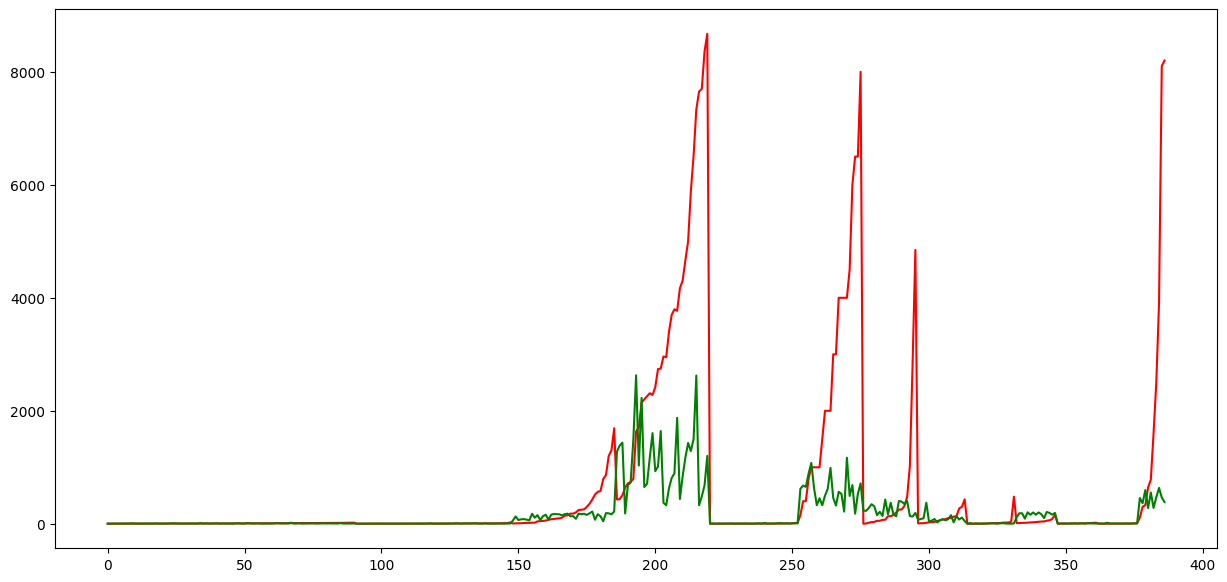

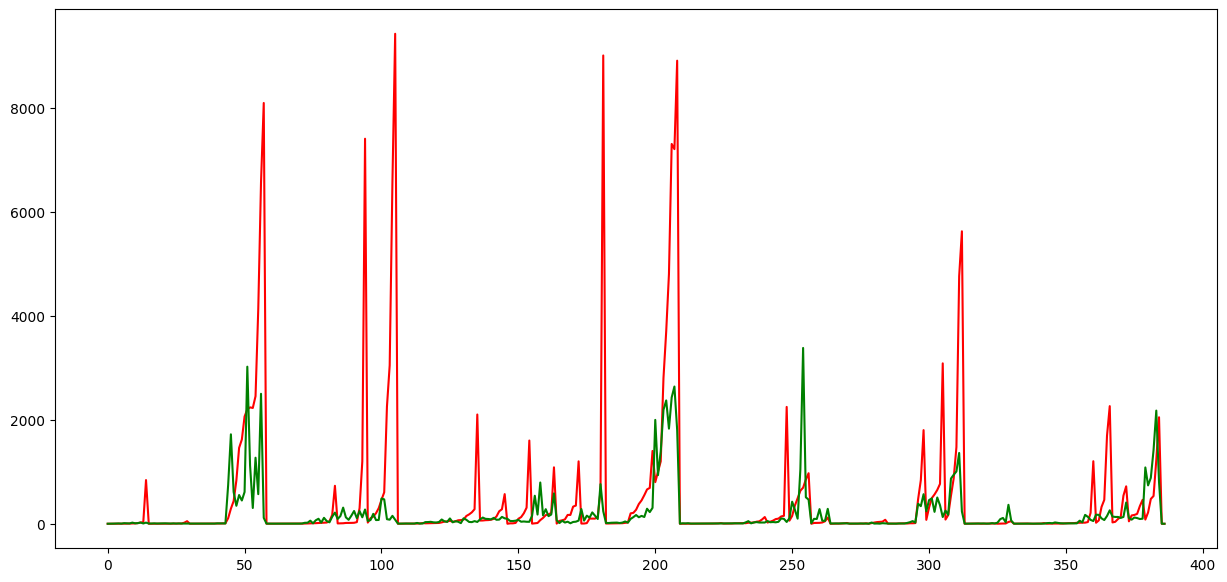

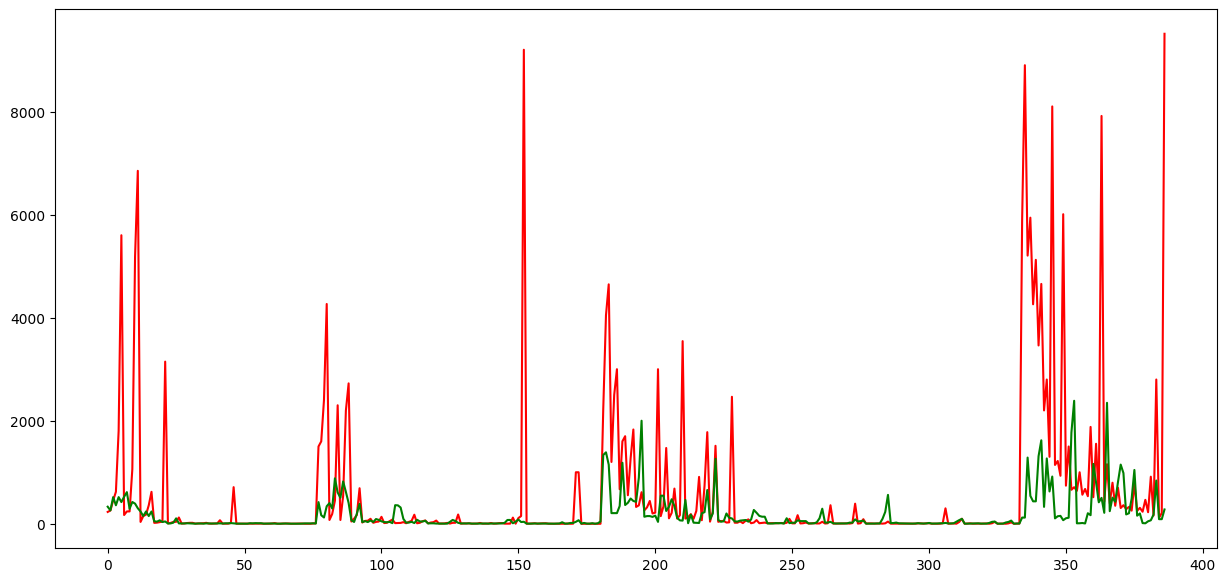

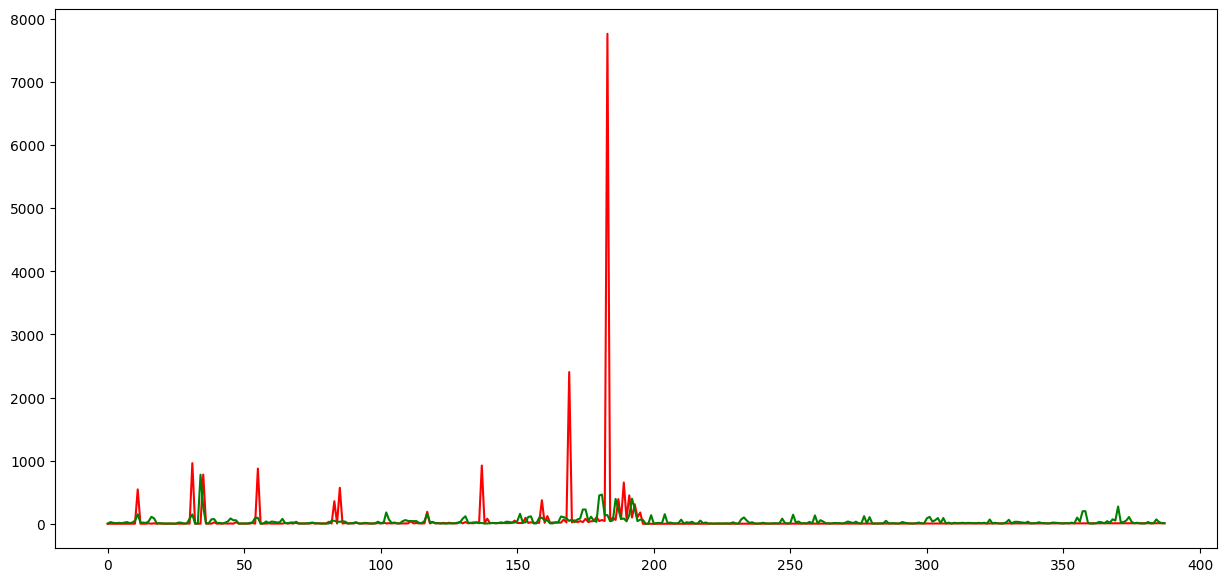

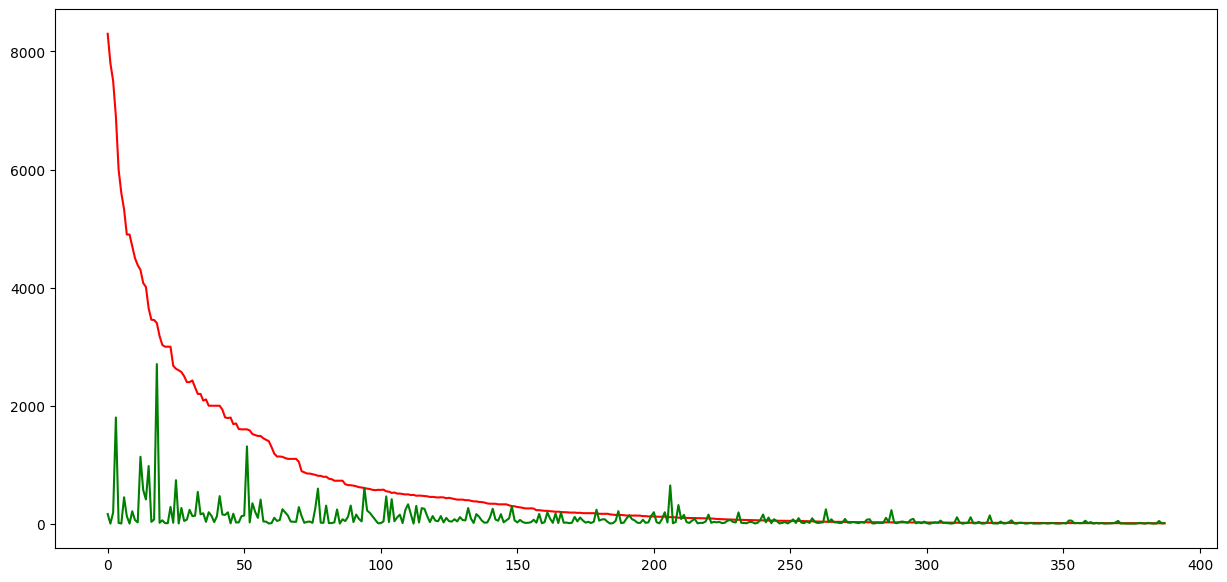

In [ ]:
is_model = 'cat'

for fold in splitter.k_fold_split(dataset, k = n_folds, seed = seed):
  train_indices = fold[0].X.astype(int)
  valid_indices = fold[1].X.astype(int)

  train_df = train.iloc[train_indices].reset_index(drop = True)
  valid_df = train.iloc[valid_indices].reset_index(drop = True)

  drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
       'Standard Units', 'Target ChEMBL ID', 'Target Name',
       'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

  train_df = train_df.drop(drop_cols, axis = 1)
  valid_df = valid_df.drop(drop_cols, axis = 1)

  X_train = train_df.drop(target_element + goal_element, axis = 1)
  y_train = train_df[target_element[0]]
  g_train = train_df[goal_element[0]]

  X_valid = valid_df.drop(target_element + goal_element, axis = 1)
  y_valid = valid_df[target_element[0]]
  g_valid = valid_df[goal_element[0]]

  if is_model == 'lgb':

    trained_model = lgb.LGBMRegressor(**lgb_params, random_state = CFG['SEED']).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], callbacks = [lgb.log_evaluation(10), lgb.early_stopping(20, verbose = 0)], eval_metric="rmse")
    valid_pred = trained_model.predict(X_valid)
    test_pred = trained_model.predict(test_df)

  elif is_model == 'cat':

    train_pool = Pool(X_train, y_train) # , cat_features = cat_cols
    valid_pool = Pool(X_valid, y_valid) # , cat_features = cat_cols

    trained_model = CatBoostRegressor(**cat_params, random_state = CFG['SEED']).fit(train_pool, eval_set = valid_pool, verbose = 0, early_stopping_rounds = 20)
    valid_pred = trained_model.predict(X_valid)
    test_pred = trained_model.predict(test_df)

  elif is_model == 'xgb':

    trained_model = xgb.XGBRegressor(**xgb_params, random_state = CFG['SEED']).fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse', verbose = 0)
    valid_pred = trained_model.predict(X_valid)
    test_pred = trained_model.predict(test_df)

  valid_pred = pIC50_to_IC50(valid_pred)
  test_pred = pIC50_to_IC50(test_pred)
  valid_score = calculate_score(g_valid, valid_pred)

  plt.figure(figsize = (15, 7))
  plt.plot(g_valid, color = 'r')
  plt.plot(valid_pred, color = 'g')
  plt.show()

  valid_preds.append(valid_pred)
  test_preds.append(test_pred)
  valid_scores.append(valid_score)

In [ ]:
np.mean(valid_scores)

0.7248453950394949

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/newdrug/sample_submission.csv')
submission

,ID,IC50_nM
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
108,TEST_108,0
109,TEST_109,0
110,TEST_110,0
111,TEST_111,0


In [ ]:
submission['IC50_nM'] = np.mean(test_preds, axis = 0)

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       113 non-null    object 
 1   IC50_nM  113 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


<Axes: >

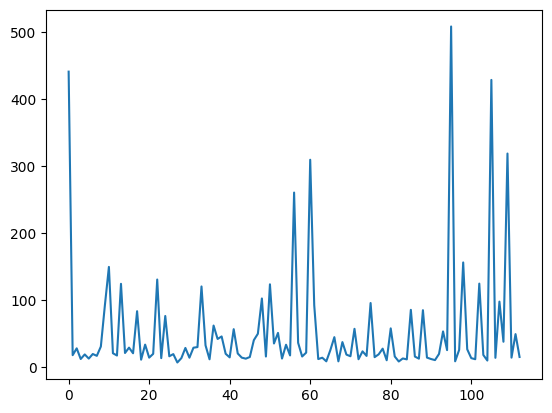

In [ ]:
submission['IC50_nM'].plot()

In [ ]:
submission.to_csv('submission_lgb.csv', index = False)

In [ ]:
# CatBoost # LightGBM # XGBoost

n_folds = 5
seed = CFG['SEED']

target_element = ['pIC50']
goal_element = ['IC50_nM']
y = train[goal_element]

def lgb_objective(trial):

  valid_scores = []

  dataset = dc.data.NumpyDataset(X = np.arange(len(train['Smiles'])), y = y, w = np.zeros(len(train['Smiles'])), ids = train['Smiles'].values)
  # dataset = dc.data.DiskDataset.from_numpy(X = np.arange(len(X['Smiles'])), y = y, w = np.zeros(len(X['Smiles'])), ids = train['Smiles'].values)

  splitter = dc.splits.ScaffoldSplitter()
  # splitter = dc.splits.RandomSplitter()
  # splitter = dc.splits.FingerprintSplitter()

  for fold in splitter.k_fold_split(dataset, k = n_folds, seed = seed):
    train_indices = fold[0].X.astype(int)
    valid_indices = fold[1].X.astype(int)

    train_df = train.iloc[train_indices].reset_index(drop = True)
    valid_df = train.iloc[valid_indices].reset_index(drop = True)

    drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
        'Standard Units', 'Target ChEMBL ID', 'Target Name',
        'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

    train_df = train_df.drop(drop_cols, axis = 1)
    valid_df = valid_df.drop(drop_cols, axis = 1)

    X_train = train_df.drop(target_element + goal_element, axis = 1)
    y_train = train_df[goal_element]

    X_valid = valid_df.drop([target_element + goal_element], axis = 1)
    y_valid = valid_df[goal_element]

    lgb_params = {
      # "n_estimators": trial.suggest_int("n_estimators", 1000, 3000, step=500),
      # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
      # "colsample_bytree":trial.suggest_float("colsample_bytree", 0.5, 1.0),
      # "colsample_bynode":trial.suggest_float('colsample_bynode', 0.5, 1.0),
      # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-2, 10.0),
      # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 10.0),
      # "max_depth": trial.suggest_int("max_depth", 3, 20),
      # "num_leaves": trial.suggest_int("num_leaves", 16, 500),
      # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 50),
      # 'random_seed': CFG['SEED'],
      # 'metric': 'rmse',
      # 'device': 'gpu',
      # 'gpu_platform_id': 0,
      # 'gpu_device_id': 0,

      "n_estimators": trial.suggest_int("n_estimators", 1000, 3000, step=500),
      'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
      'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.2, 1.0),
      'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
      'max_depth': trial.suggest_categorical('max_depth', [5,10,20,40,100, -1]),
      'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
      'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
      'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
      'random_seed': CFG['SEED'],
      'metric': 'rmse',
      'device': 'gpu',
      'gpu_platform_id': 0,
      'gpu_device_id': 0,
    }

    trained_model = lgb.LGBMRegressor(**lgb_params).fit(X_train, y_valid, eval_set = [(X_train, y_train), (X_valid, y_valid)], callbacks = [lgb.log_evaluation(10), lgb.early_stopping(20, verbose = 0)], eval_metric = custom_lgbm_metric)
    valid_pred = trained_model.predict(X_valid)

    valid_score = calculate_score(y_valid, valid_pred)
    # valid_score = mean_squared_error(y_valid, valid_pred,squared=False)
    valid_scores.append(valid_score)

  return np.mean(valid_scores)

study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed = CFG['SEED'])) # , pruner=SuccessiveHalvingPruner()
study.optimize(lgb_objective, n_trials = n_trials, show_progress_bar=True)

print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(trial.value))

print('Best parameters: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

print('Best Params :', study.best_params)

In [ ]:
def cat_objective(trial):

  valid_scores = []

  dataset = dc.data.NumpyDataset(X = np.arange(len(train['Smiles'])), y = y, w = np.zeros(len(train['Smiles'])), ids = train['Smiles'].values)
  # dataset = dc.data.DiskDataset.from_numpy(X = np.arange(len(X['Smiles'])), y = y, w = np.zeros(len(X['Smiles'])), ids = train['Smiles'].values)

  splitter = dc.splits.ScaffoldSplitter()
  # splitter = dc.splits.RandomSplitter()
  # splitter = dc.splits.FingerprintSplitter()

  for fold in splitter.k_fold_split(dataset, k = n_folds, seed = seed):
    train_indices = fold[0].X.astype(int)
    valid_indices = fold[1].X.astype(int)

    train_df = train.iloc[train_indices].reset_index(drop = True)
    valid_df = train.iloc[valid_indices].reset_index(drop = True)

    drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
        'Standard Units', 'Target ChEMBL ID', 'Target Name',
        'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

    train_df = train_df.drop(drop_cols, axis = 1)
    valid_df = valid_df.drop(drop_cols, axis = 1)

    X_train = train_df.drop(target_element + goal_element, axis = 1)
    y_train = train_df[goal_element]

    X_valid = valid_df.drop([target_element + goal_element], axis = 1)
    y_valid = valid_df[goal_element]

    cat_params = {
      'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=500),
      "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
      'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
      'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 20.0),
      'random_strength': trial.suggest_float('random_strength', 1.0, 2.0),
      'depth': trial.suggest_int('depth', 2, 10),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
      "use_best_model": True,
      'random_seed': CFG['SEED'],
      "task_type": "GPU",
    }

    train_pool = Pool(X_train, y_train) # , cat_features = cat_cols
    valid_pool = Pool(X_valid, y_valid) # , cat_features = cat_cols

    trained_model = CatBoostRegressor(**cat_params).fit(train_pool, eval_set = valid_pool, verbose = 0, early_stopping_rounds = 20)
    valid_pred = trained_model.predict(X_valid)

    valid_score = calculate_score(y_valid, valid_pred)
    # valid_score = mean_squared_error(y_valid, valid_pred,squared=False)
    valid_scores.append(valid_score)

  return np.mean(valid_scores)

study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed = CFG['SEED'])) # , pruner=SuccessiveHalvingPruner()
study.optimize(lgb_objective, n_trials = n_trials, show_progress_bar=True)

print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(trial.value))

print('Best parameters: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

print('Best Params :', study.best_params)

In [ ]:
def xgb_objective(trial):

  valid_scores = []

  dataset = dc.data.NumpyDataset(X = np.arange(len(train['Smiles'])), y = y, w = np.zeros(len(train['Smiles'])), ids = train['Smiles'].values)
  # dataset = dc.data.DiskDataset.from_numpy(X = np.arange(len(X['Smiles'])), y = y, w = np.zeros(len(X['Smiles'])), ids = train['Smiles'].values)

  splitter = dc.splits.ScaffoldSplitter()
  # splitter = dc.splits.RandomSplitter()
  # splitter = dc.splits.FingerprintSplitter()

  for fold in splitter.k_fold_split(dataset, k = n_folds, seed = seed):
    train_indices = fold[0].X.astype(int)
    valid_indices = fold[1].X.astype(int)

    train_df = train.iloc[train_indices].reset_index(drop = True)
    valid_df = train.iloc[valid_indices].reset_index(drop = True)

    drop_cols = ['Molecule ChEMBL ID', 'Standard Type', 'Standard Relation',
        'Standard Units', 'Target ChEMBL ID', 'Target Name',
        'Target Organism', 'Target Type', 'Smiles'] + ['Assay ChEMBL ID', 'Document ChEMBL ID']

    train_df = train_df.drop(drop_cols, axis = 1)
    valid_df = valid_df.drop(drop_cols, axis = 1)

    X_train = train_df.drop(target_element + goal_element, axis = 1)
    y_train = train_df[goal_element]

    X_valid = valid_df.drop([target_element + goal_element], axis = 1)
    y_valid = valid_df[goal_element]

    xgb_params = {
      'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=500),
      "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
      'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
      'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
      'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
      'subsample': trial.suggest_int('subsample', 0.4, 1.0),
      'max_depth': trial.suggest_int('max_depth', 2, 10),
      'random_seed': CFG['SEED'],
      'tree_method':'gpu_hist',
    }

    trained_model = xgb.XGBRegressor(**xgb_params).fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 0)
    valid_pred = trained_model.predict(X_valid)

    valid_score = calculate_score(y_valid, valid_pred)
    # valid_score = mean_squared_error(y_valid, valid_pred,squared=False)
    valid_scores.append(valid_score)

  return np.mean(valid_scores)

study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed = CFG['SEED'])) # , pruner=SuccessiveHalvingPruner()
study.optimize(lgb_objective, n_trials = n_trials, show_progress_bar=True)

print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(trial.value))

print('Best parameters: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

print('Best Params :', study.best_params)

In [ ]:
def load_model(model_class, checkpoint_path, device):
  model = model_class.to(device)
  model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True)) # map_location=device, weights_only=True
  return model

def inference(model, dataloader, device, use_meta=False):
  predictions = []
  bar = tqdm(dataloader, desc='Inference', total=len(dataloader), leave=False)
  model.eval()

  with torch.no_grad():
    for batch in bar:
      if use_meta:
        tabular_data, fingerprint_data, graph_data = batch
        tabular_data, fingerprint_data, graph_data = (
            tabular_data.to(device, dtype=torch.float),
            fingerprint_data.to(device, dtype=torch.float),
            graph_data.to(device),
        )

        output = model(graph_data, tabular_data, fingerprint_data).squeeze()

      else:
        _, fingerprint_data, graph_data = batch
        fingerprint_data, graph_data = (
            fingerprint_data.to(device, dtype=torch.float),
            graph_data.to(device),
        )

        output = model(graph_data).squeeze()

      predictions.append(output.detach().cpu())

  predictions = torch.cat(predictions)

  predictions_tp = pIC50_to_IC50_custom(predictions.numpy())
  # predictions_tp = predictions.numpy()
  return predictions_tp

In [ ]:
test.shape

(113, 264)

In [ ]:
# n_folds = 5
# seed = CFG['SEED']
# target_element = ['pIC50']
# goal_element = ['IC50_nM']

In [ ]:
def process_fold(fold_idx):
  print(f'Processing fold: {fold_idx + 1}')

  test_df = test.reset_index(drop = True)
  test_smiles_list = test_df['Smiles'].tolist()

  drop_cols = ['ID', 'Smiles']

  test_df = test_df.drop(drop_cols, axis = 1)

  test_dataset = NewDrugDataset(df = test_df, smile_list = test_smiles_list, df_fingerprint = df_fingerprint_t, mode = 'test') # scaler = scalers[fold_idx], selector = selectors[fold_idx]

  test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

  fold_checkpoint_path = f'best_fold_{fold_idx + 1}.pth'
  model_class = GAT_GCN(
      node_dim=NODE_DIM,
      edge_dim=EDGE_DIM,
      fps_dim=399, # selector_dim_fold[fold_idx]
      num_heads=4,
      emb_dim=EMB_DIM,
      meta_dim=n_meta_features,
      n_meta_dim=[1024, 512, 256, 128],
      out_dim=1,
      device=device
  )
  model = load_model(model_class, fold_checkpoint_path, device)
  return inference(model, test_dataloader, device, use_meta=use_meta)

# test_predictions_folds = joblib.Parallel(n_jobs=5)(joblib.delayed(process_fold)(fold_idx) for fold_idx in range(n_folds))
test_predictions_folds = [process_fold(fold_idx) for fold_idx in range(n_folds)]

submission_predictions = np.mean(test_predictions_folds, axis=0)

Processing fold: 1


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Processing fold: 2


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Processing fold: 3


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Processing fold: 4


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Processing fold: 5


Inference:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
submission_predictions = np.where(submission_predictions == 0, train['IC50_nM'].min(), submission_predictions)

In [ ]:
submission_predictions.shape

(113,)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/newdrug/sample_submission.csv')
submission

,ID,IC50_nM
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
108,TEST_108,0
109,TEST_109,0
110,TEST_110,0
111,TEST_111,0


<Axes: >

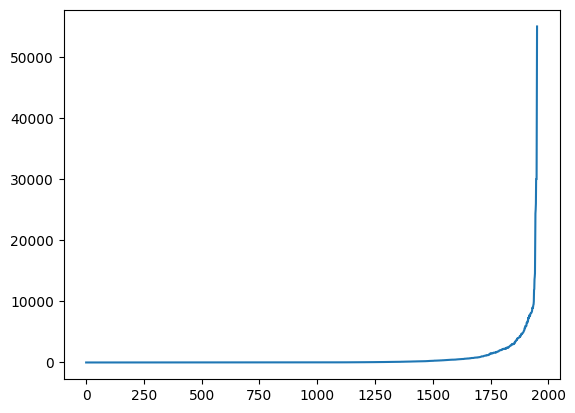

In [ ]:
train['IC50_nM'].plot()

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       113 non-null    object
 1   IC50_nM  113 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


In [ ]:
submission['IC50_nM'] = submission_predictions.astype('float64')

<Axes: >

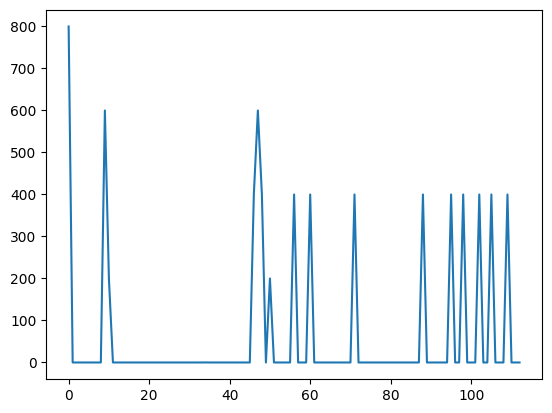

In [ ]:
submission['IC50_nM'].plot()

In [ ]:
submission.to_csv('submission_gatgcn.csv', index = False)

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       113 non-null    object 
 1   IC50_nM  113 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB
